In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter, zoom
from datetime import timedelta, datetime

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_37072\523238995.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


Unnamed: 0 first_day_of_the_week                         artist  \
0           0            1958-09-08               Domenico Modugno   
1           1            1958-09-08                   The Elegants   
2           2            1958-09-08            The Everly Brothers   
3           3            1958-09-08  Jimmy Clanton And His Rockets   
4           4            1958-09-08  Perez Prado And His Orchestra   

                         song_name  position  last_week_position  \
0  Nel Blu Dipinto Di Blu (Volare)         1                 1.0   
1                      Little Star         2                 2.0   
2                         Bird Dog         3                 3.0   
3                     Just A Dream         4                 4.0   
4                         Patricia         5                 6.0   

   peak_position  weeks_on_chart             songwriters   producers  \
0              1               6  F.Migliacci, D.Modugno  Not Listed   
1              1               6      V.Picone, A.Venosa  Not Listed   
2              3               6                B.Bryant  Not Listed   
3              4               6              Not Listed  Not Listed   
4              2               6       B.Marcus, P.Prado  Not Listed   

  promotion_label  year  week  
0           Decca  1958    37  
1             Apt  1958    37  
2         Cadence  1958    37  
3             Ace  1958    37  
4      RCA Victor  1958    37

In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

## Distribution of position changes for decades

In [3]:
grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

In [4]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

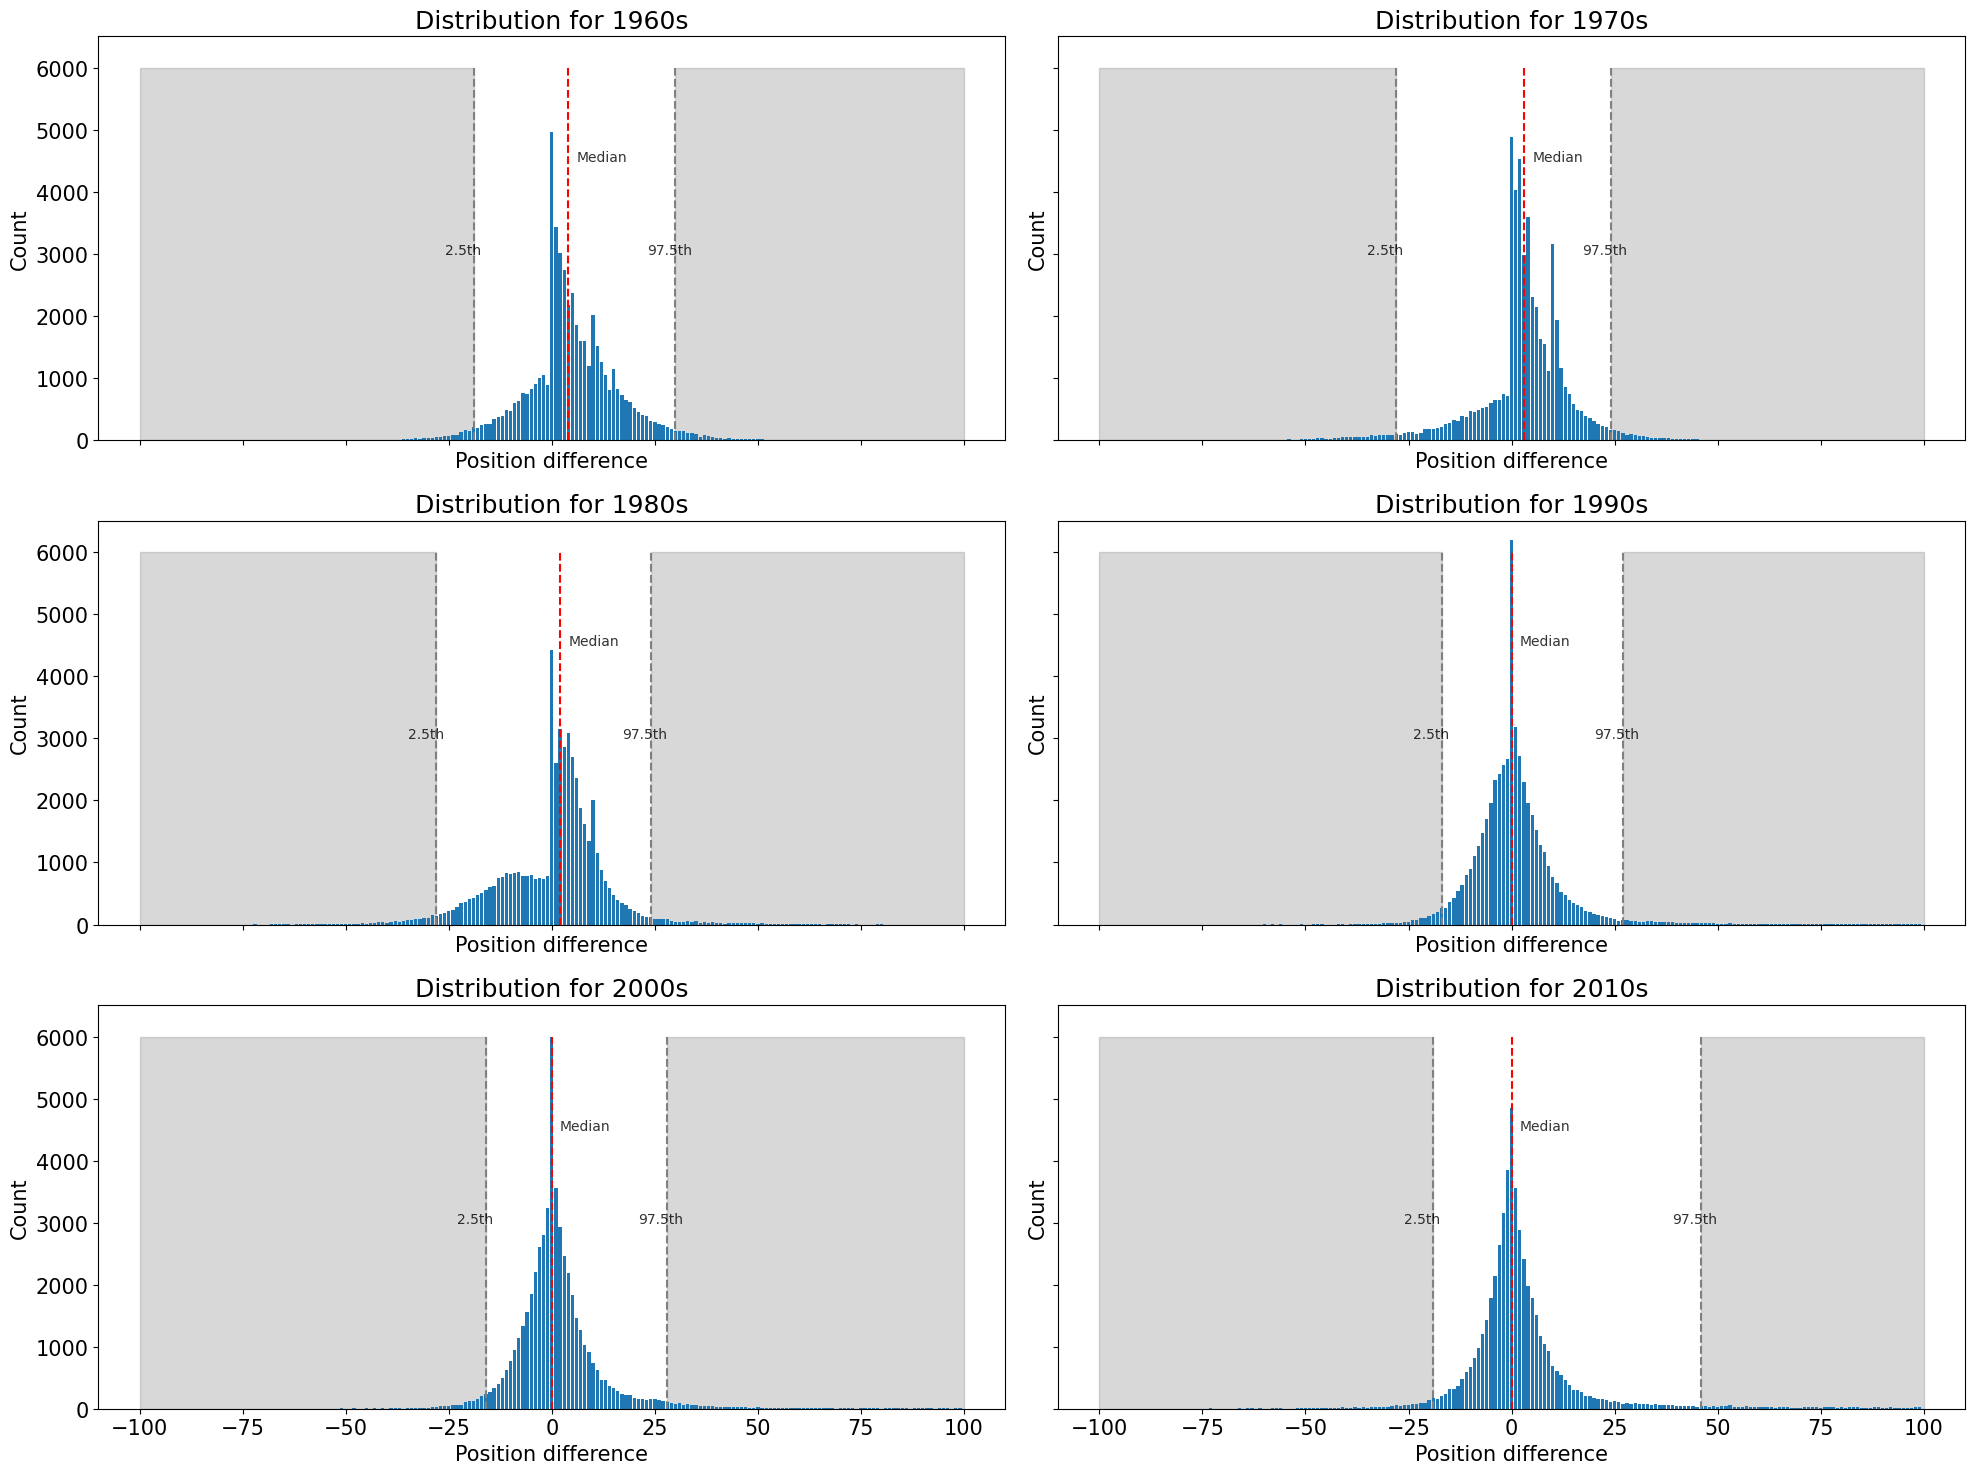

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=6000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 3000, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 3000, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 4500, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"Distribution for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
plt.savefig("figures/position_difference_distribution_decades.pdf", format="pdf")
plt.show()

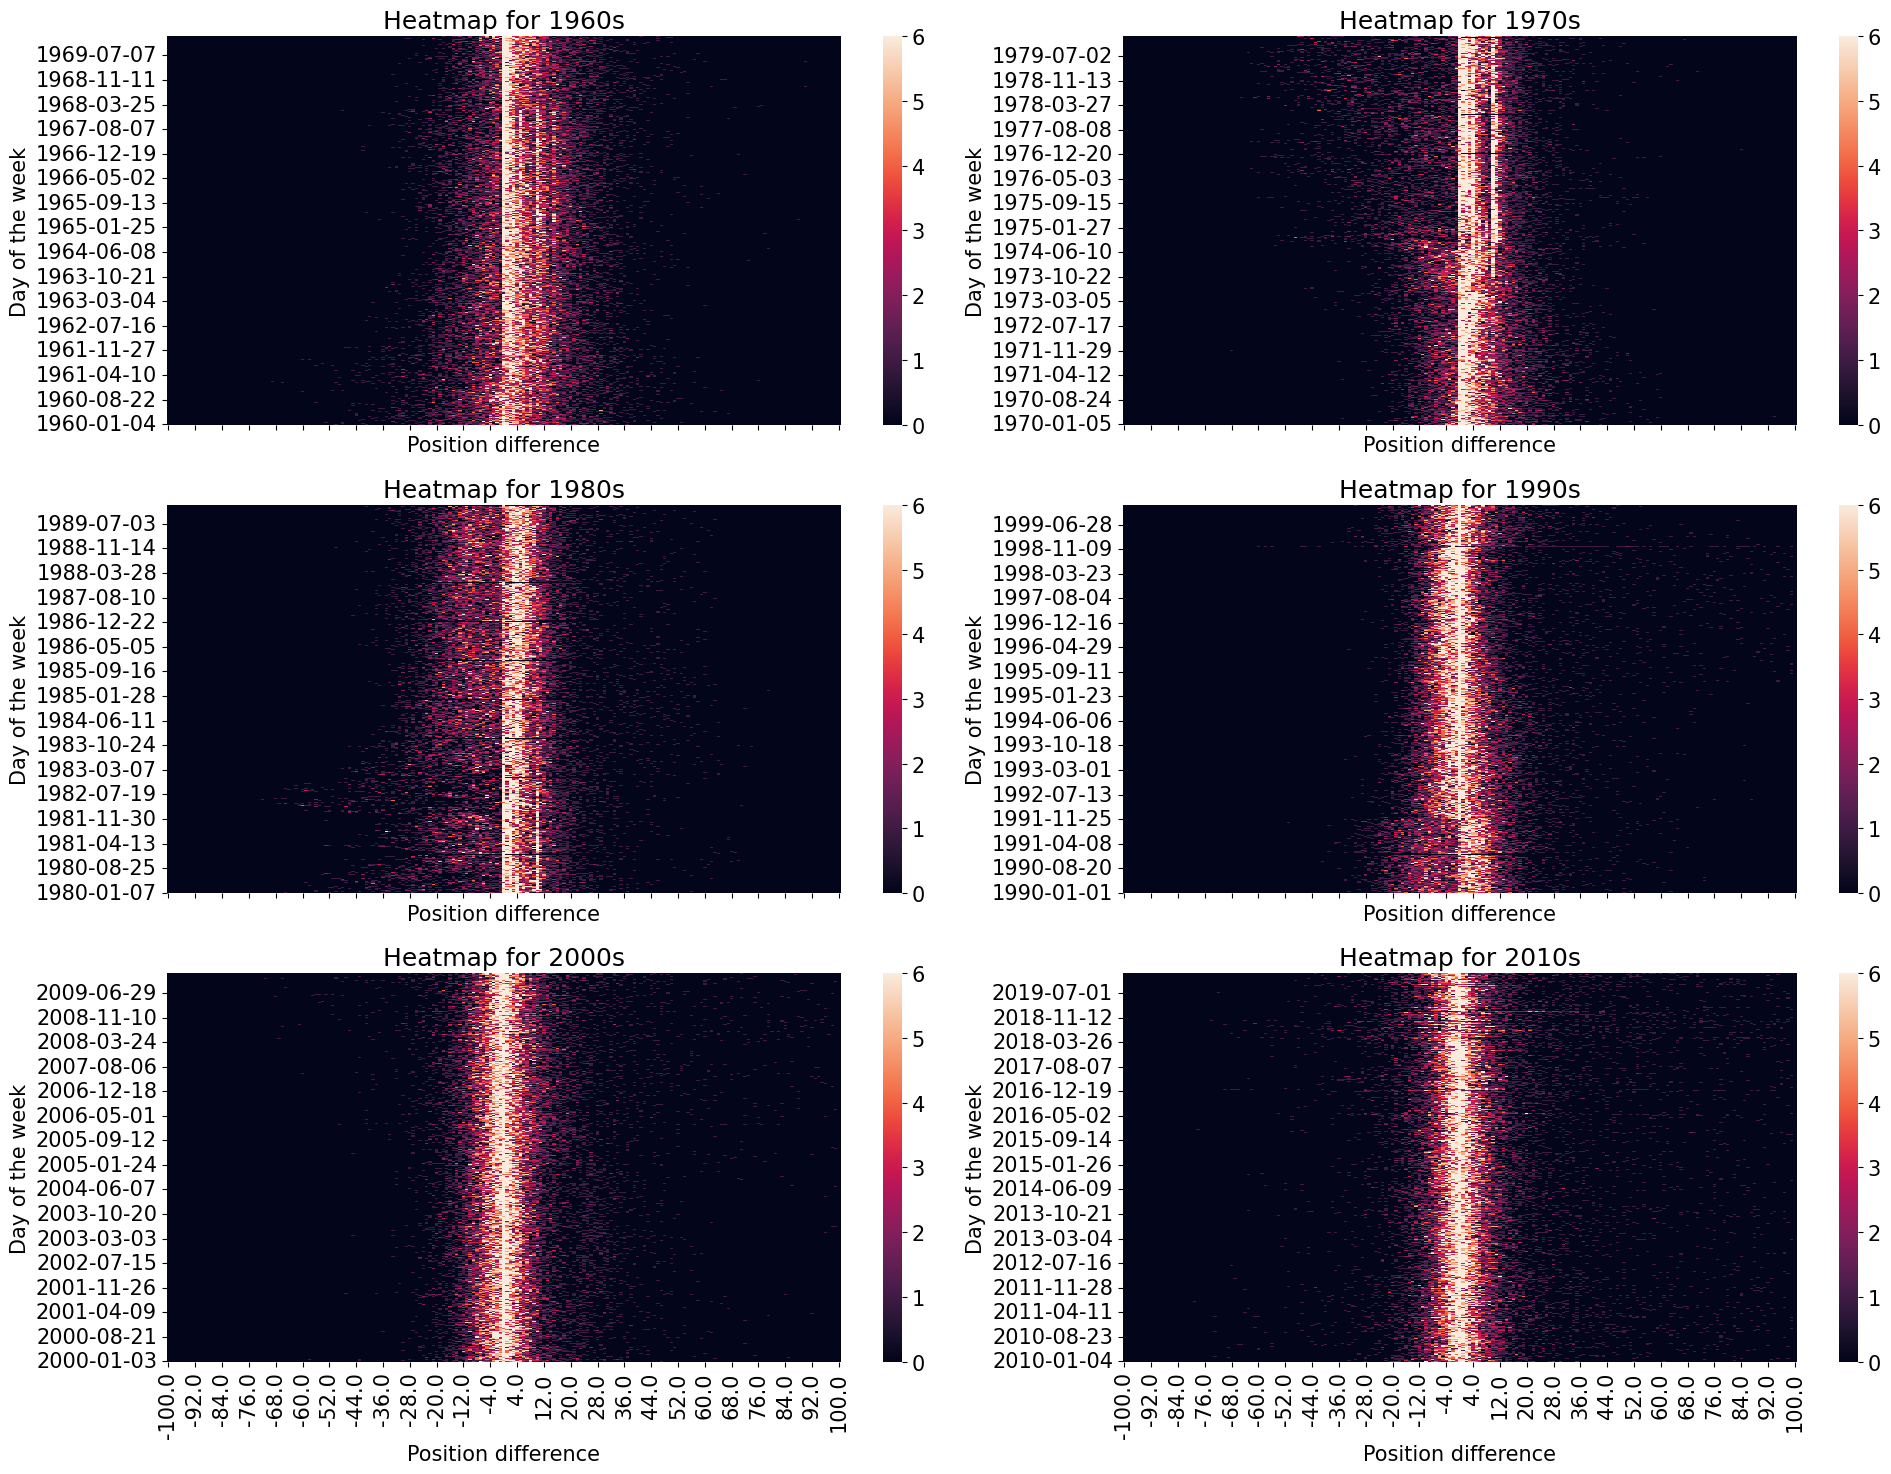

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]
    cross_tab = pd.crosstab(billboard_year_subset["first_day_of_the_week"], 
                            billboard_year_subset["position_change"])
    # adding the non existing values between -100 and 100 as columns with 0 values to present in the heatmap
    not_existing = []
    for i in range(-100, 101):
        if i not in cross_tab.columns:
            not_existing.append(i)
    not_existing_dict = dict.fromkeys(not_existing, 0)        
    temp_df = pd.DataFrame(not_existing_dict, index=cross_tab.index)
    cross_tab = pd.concat([cross_tab, temp_df], axis=1)
    cross_tab = cross_tab.reindex(sorted(cross_tab.columns), axis=1)

    sns.heatmap(cross_tab, ax=axes[row, col], cmap=sns.color_palette("rocket", as_cmap=True), robust=True,
        vmin=0, vmax=6)
    axes[row, col].set_title(f"Heatmap for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Day of the week")
    axes[row, col].set_ylim(axes[row, col].get_ylim()[::-1])

    labels = [dateutil.parser.parse(item.get_text()).strftime("%Y-%m-%d") for item in axes[row, col].yaxis.get_ticklabels()]
    axes[row, col].set_yticklabels(labels)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.xticks(rotation=90)
plt.savefig("figures/position_difference_heatmap_decades.pdf", format="pdf")
plt.show()

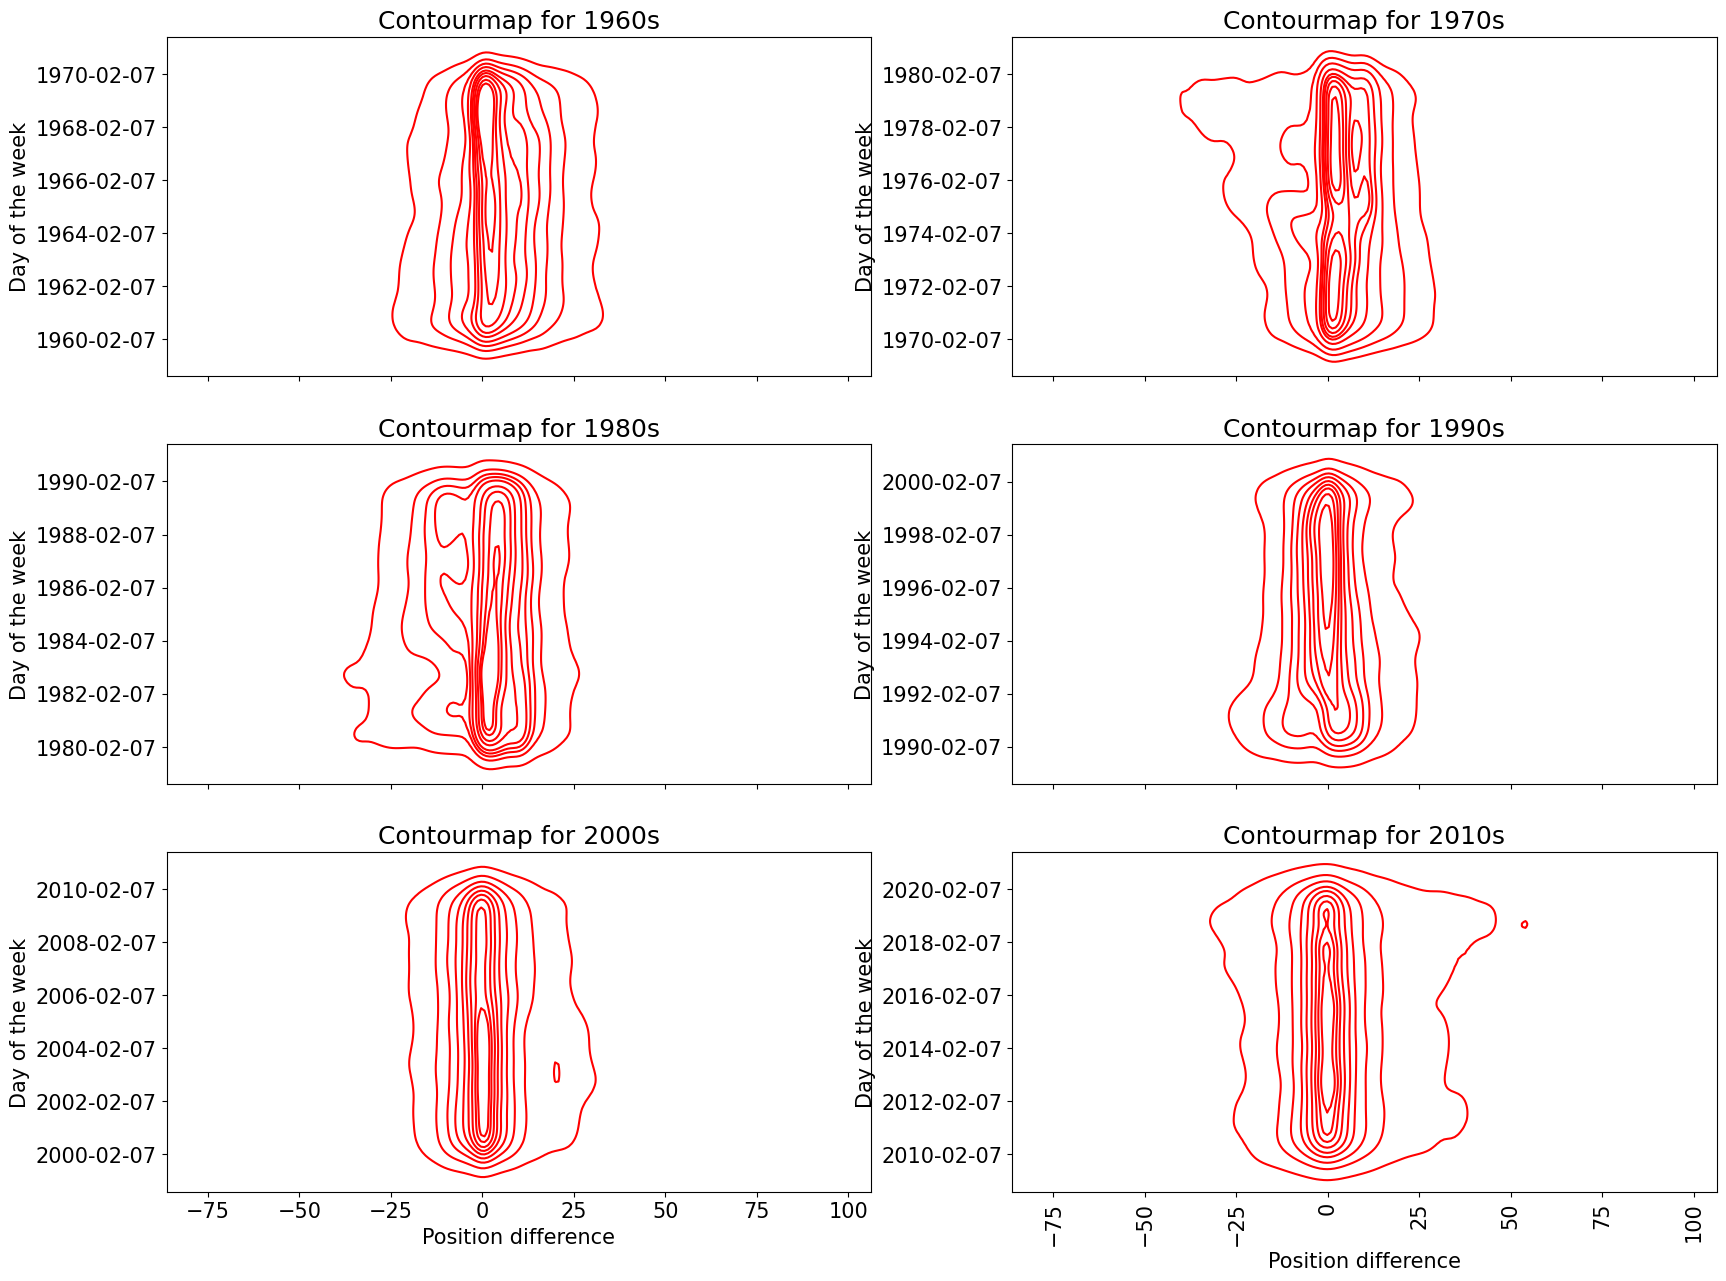

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

row = 0
col = 0

for year in range(1960, 2020, 10):
    billboard_year_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]

    sns.kdeplot(billboard_year_subset, x=billboard_year_subset["position_change"], y=billboard_year_subset["first_day_of_the_week"], ax=axes[row, col], color="red")
    axes[row, col].set_title(f"Contourmap for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Day of the week")

    labels = [dateutil.parser.parse(item.get_text()).strftime("%Y-%m-%d") for item in axes[row, col].get_yticklabels()]
    # workaround: https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator
    ticks_loc = axes[row, col].get_yticks().tolist()
    axes[row, col].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_yticklabels(labels)

    col += 1
    if col == 2:
        col = 0
        row += 1

plt.xticks(rotation=90)
plt.savefig("figures/position_difference_contourmap_decades.pdf", format="pdf")
plt.show()

## Proportion of songs older than x for decades

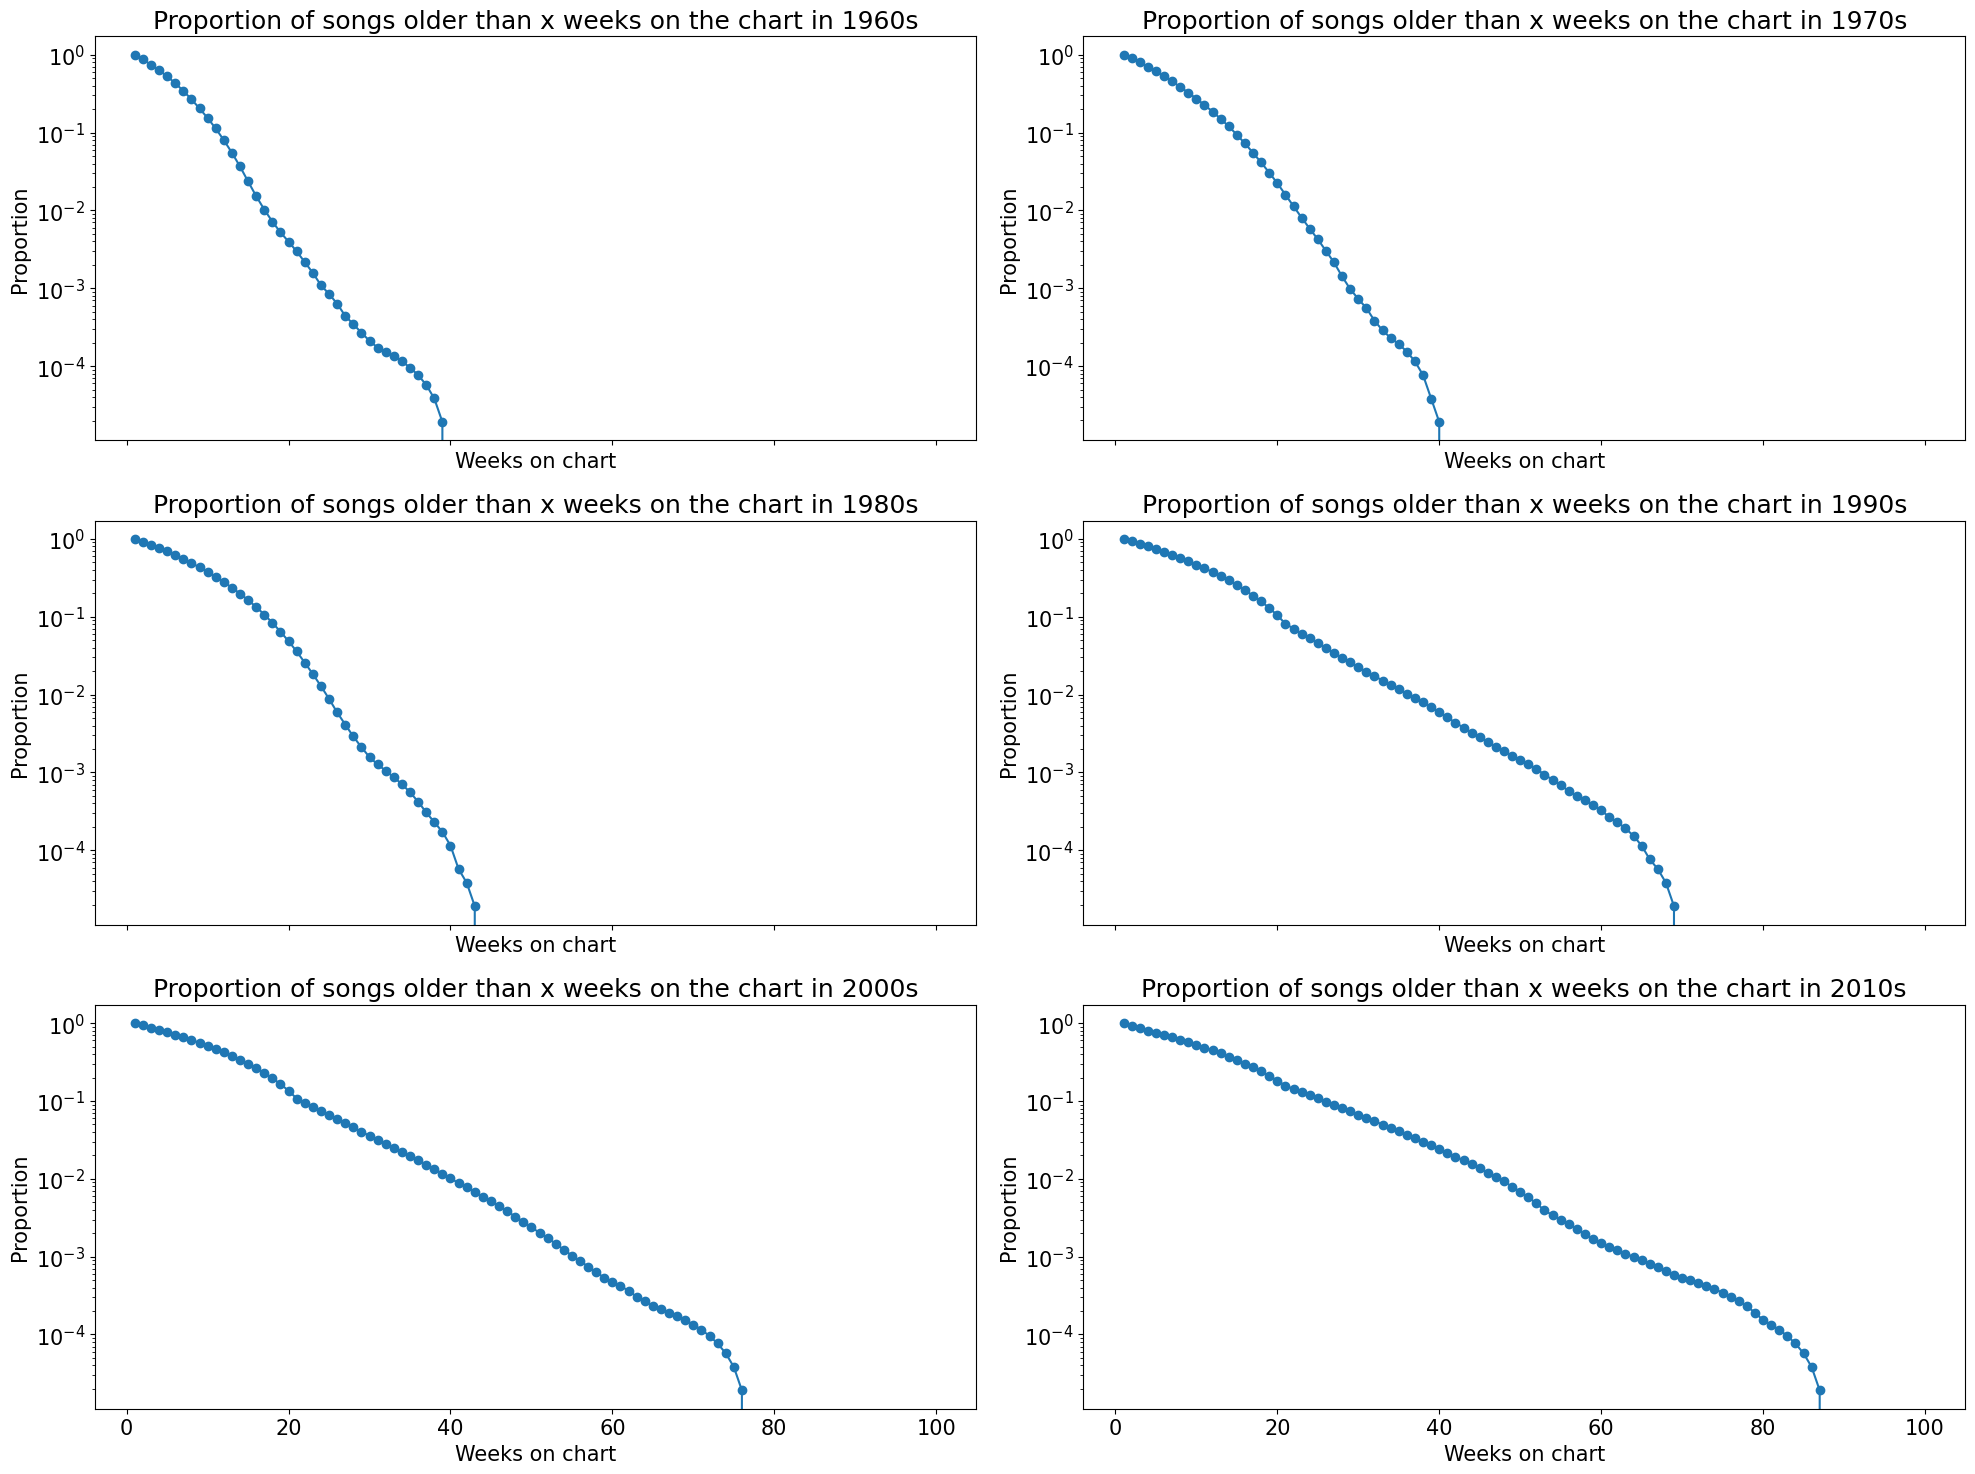

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    proportion_of_songs_older_than_x_weeks = []
    for i in range(1, 101):
        proportion_of_songs_older_than_x_weeks.append(
            billboard_hot_100[(billboard_hot_100["weeks_on_chart"] >= i) & (billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0] / billboard_hot_100[(billboard_hot_100["year"] >= year) &\
                 (billboard_hot_100["year"] < year + 10)].shape[0])
    axes[row, col].plot(range(1, 101), proportion_of_songs_older_than_x_weeks, marker='o')
    axes[row, col].set_title(f"Proportion of songs older than x weeks on the chart in {year}s")
    axes[row, col].set_xlabel("Weeks on chart")
    axes[row, col].set_ylabel("Proportion")
    axes[row, col].set_yscale("log")

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.savefig("figures/proportion_of_songs_older_than_x_weeks_decades.pdf", format="pdf")
plt.show()

## Position trajcetories of top 10 songs for decades

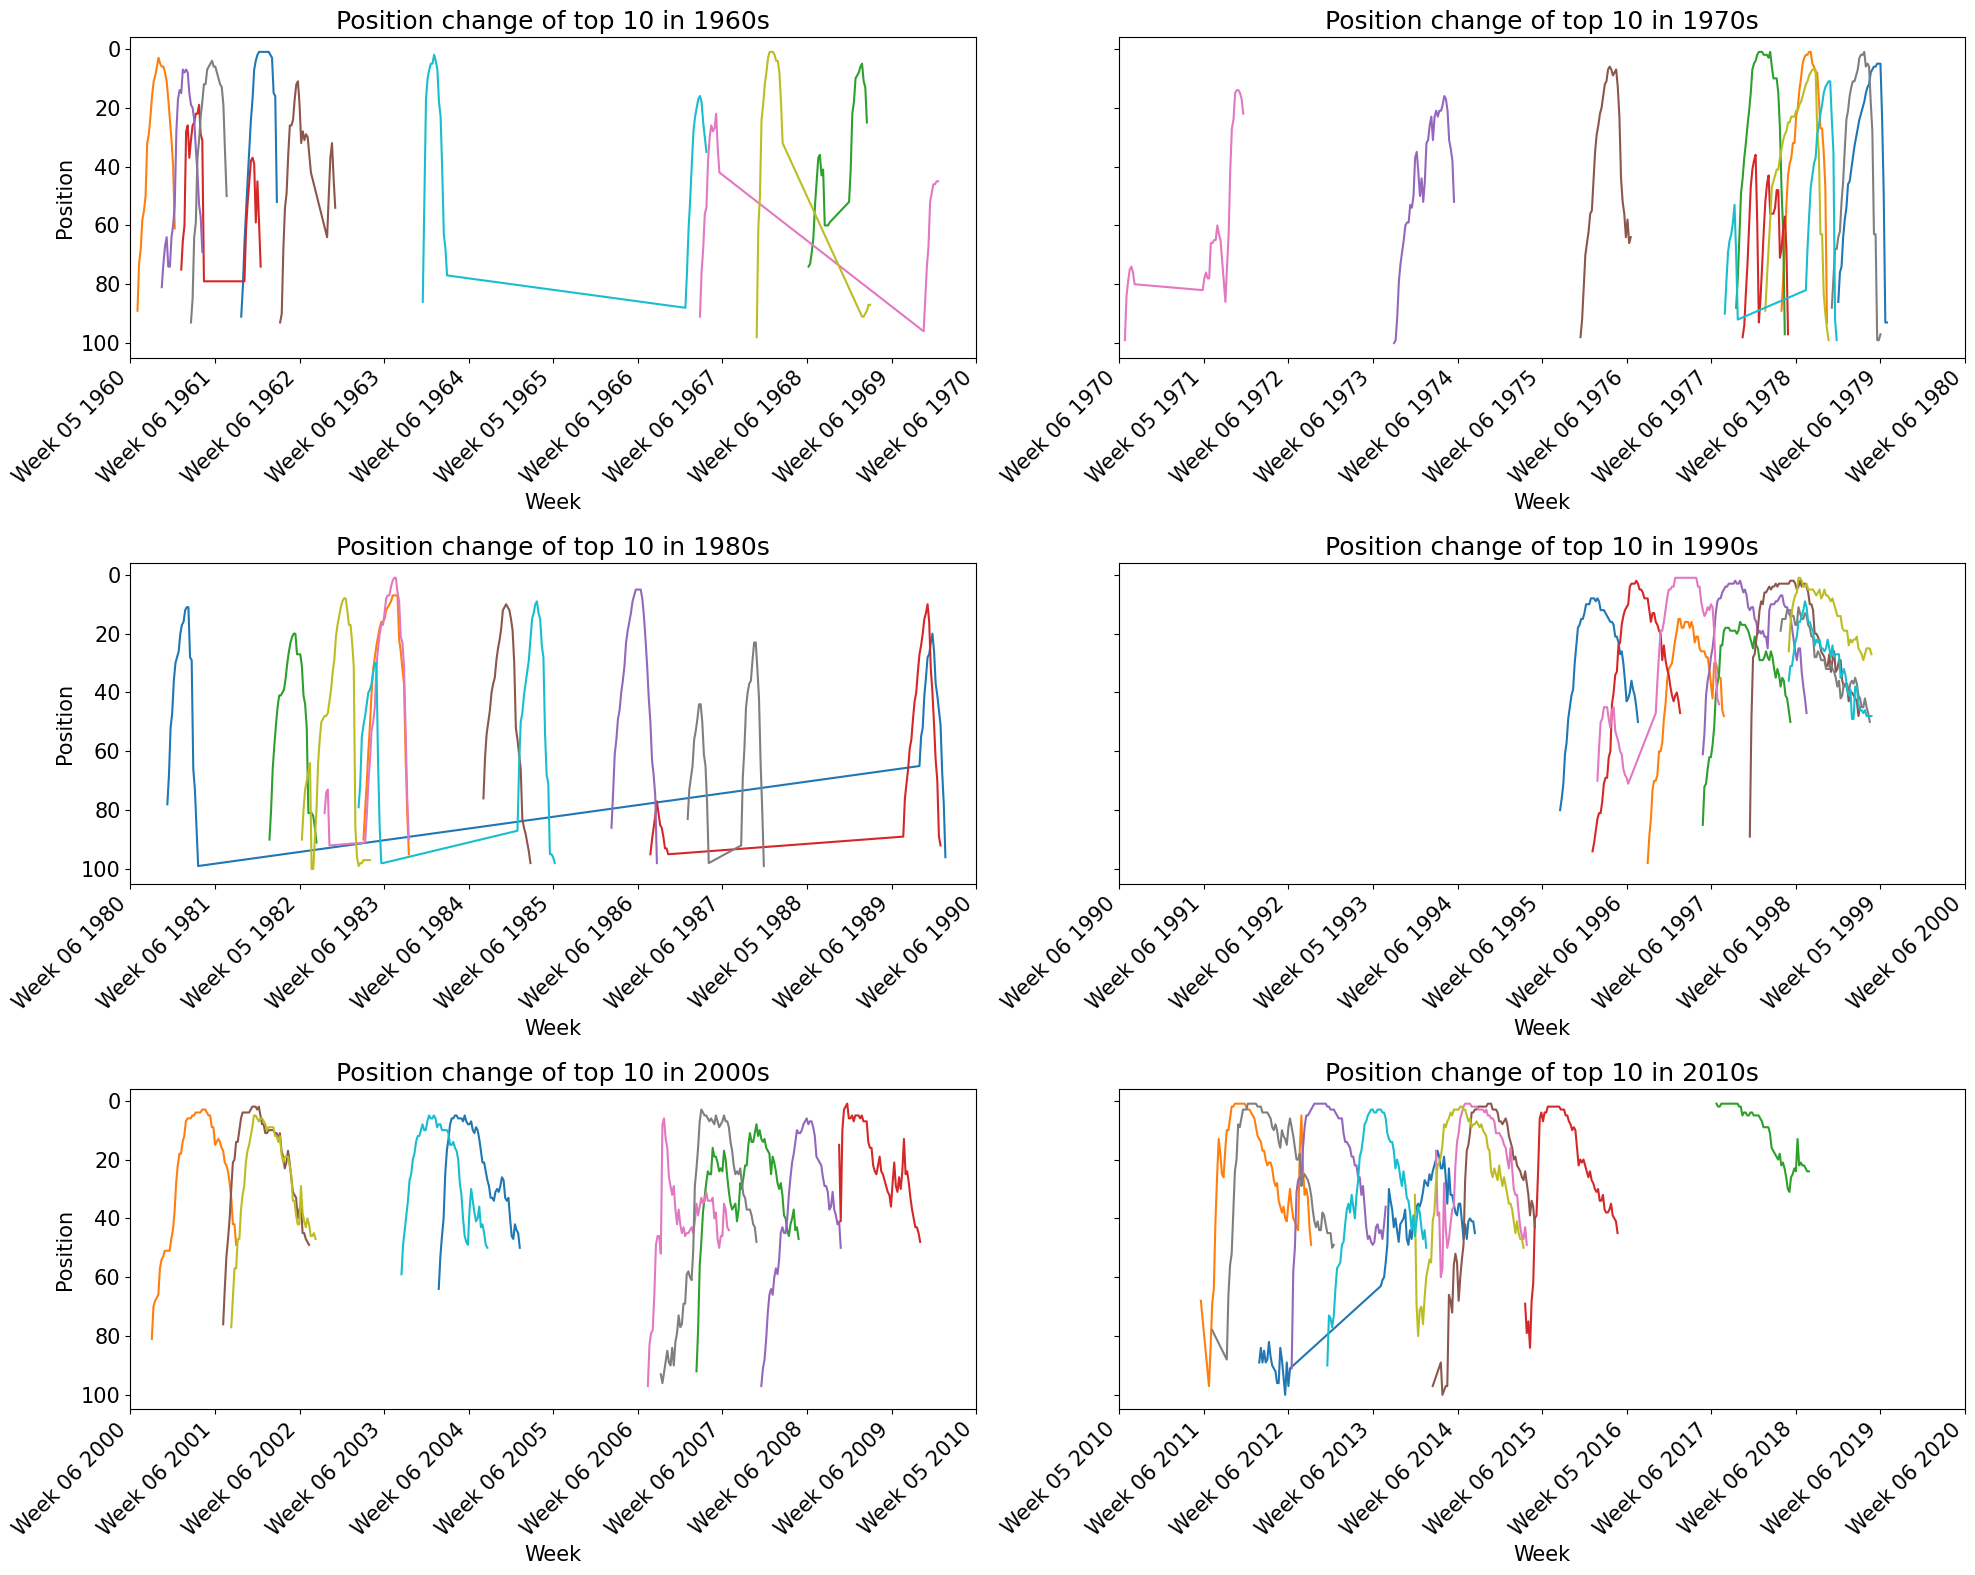

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade[~(max_weeks_on_chart_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            max_weeks_on_chart_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])

    axes[row, col].set_title(f"Position change of top 10 in {year}s")
    axes[row, col].set_xlabel("Week")
    axes[row, col].set_ylabel("Position")
    axes[row, col].set_xlim([datetime(year, 1, 1), datetime(year + 10, 1, 1)])

    labels = ["Week " + dateutil.parser.parse(item.get_text()).strftime("%V %Y") for item in axes[row, col].get_xticklabels()]
    ticks_loc = axes[row, col].get_xticks().tolist()
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=45)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades.pdf", format="pdf")
plt.show()

### Taking into consideration years before and after the decade

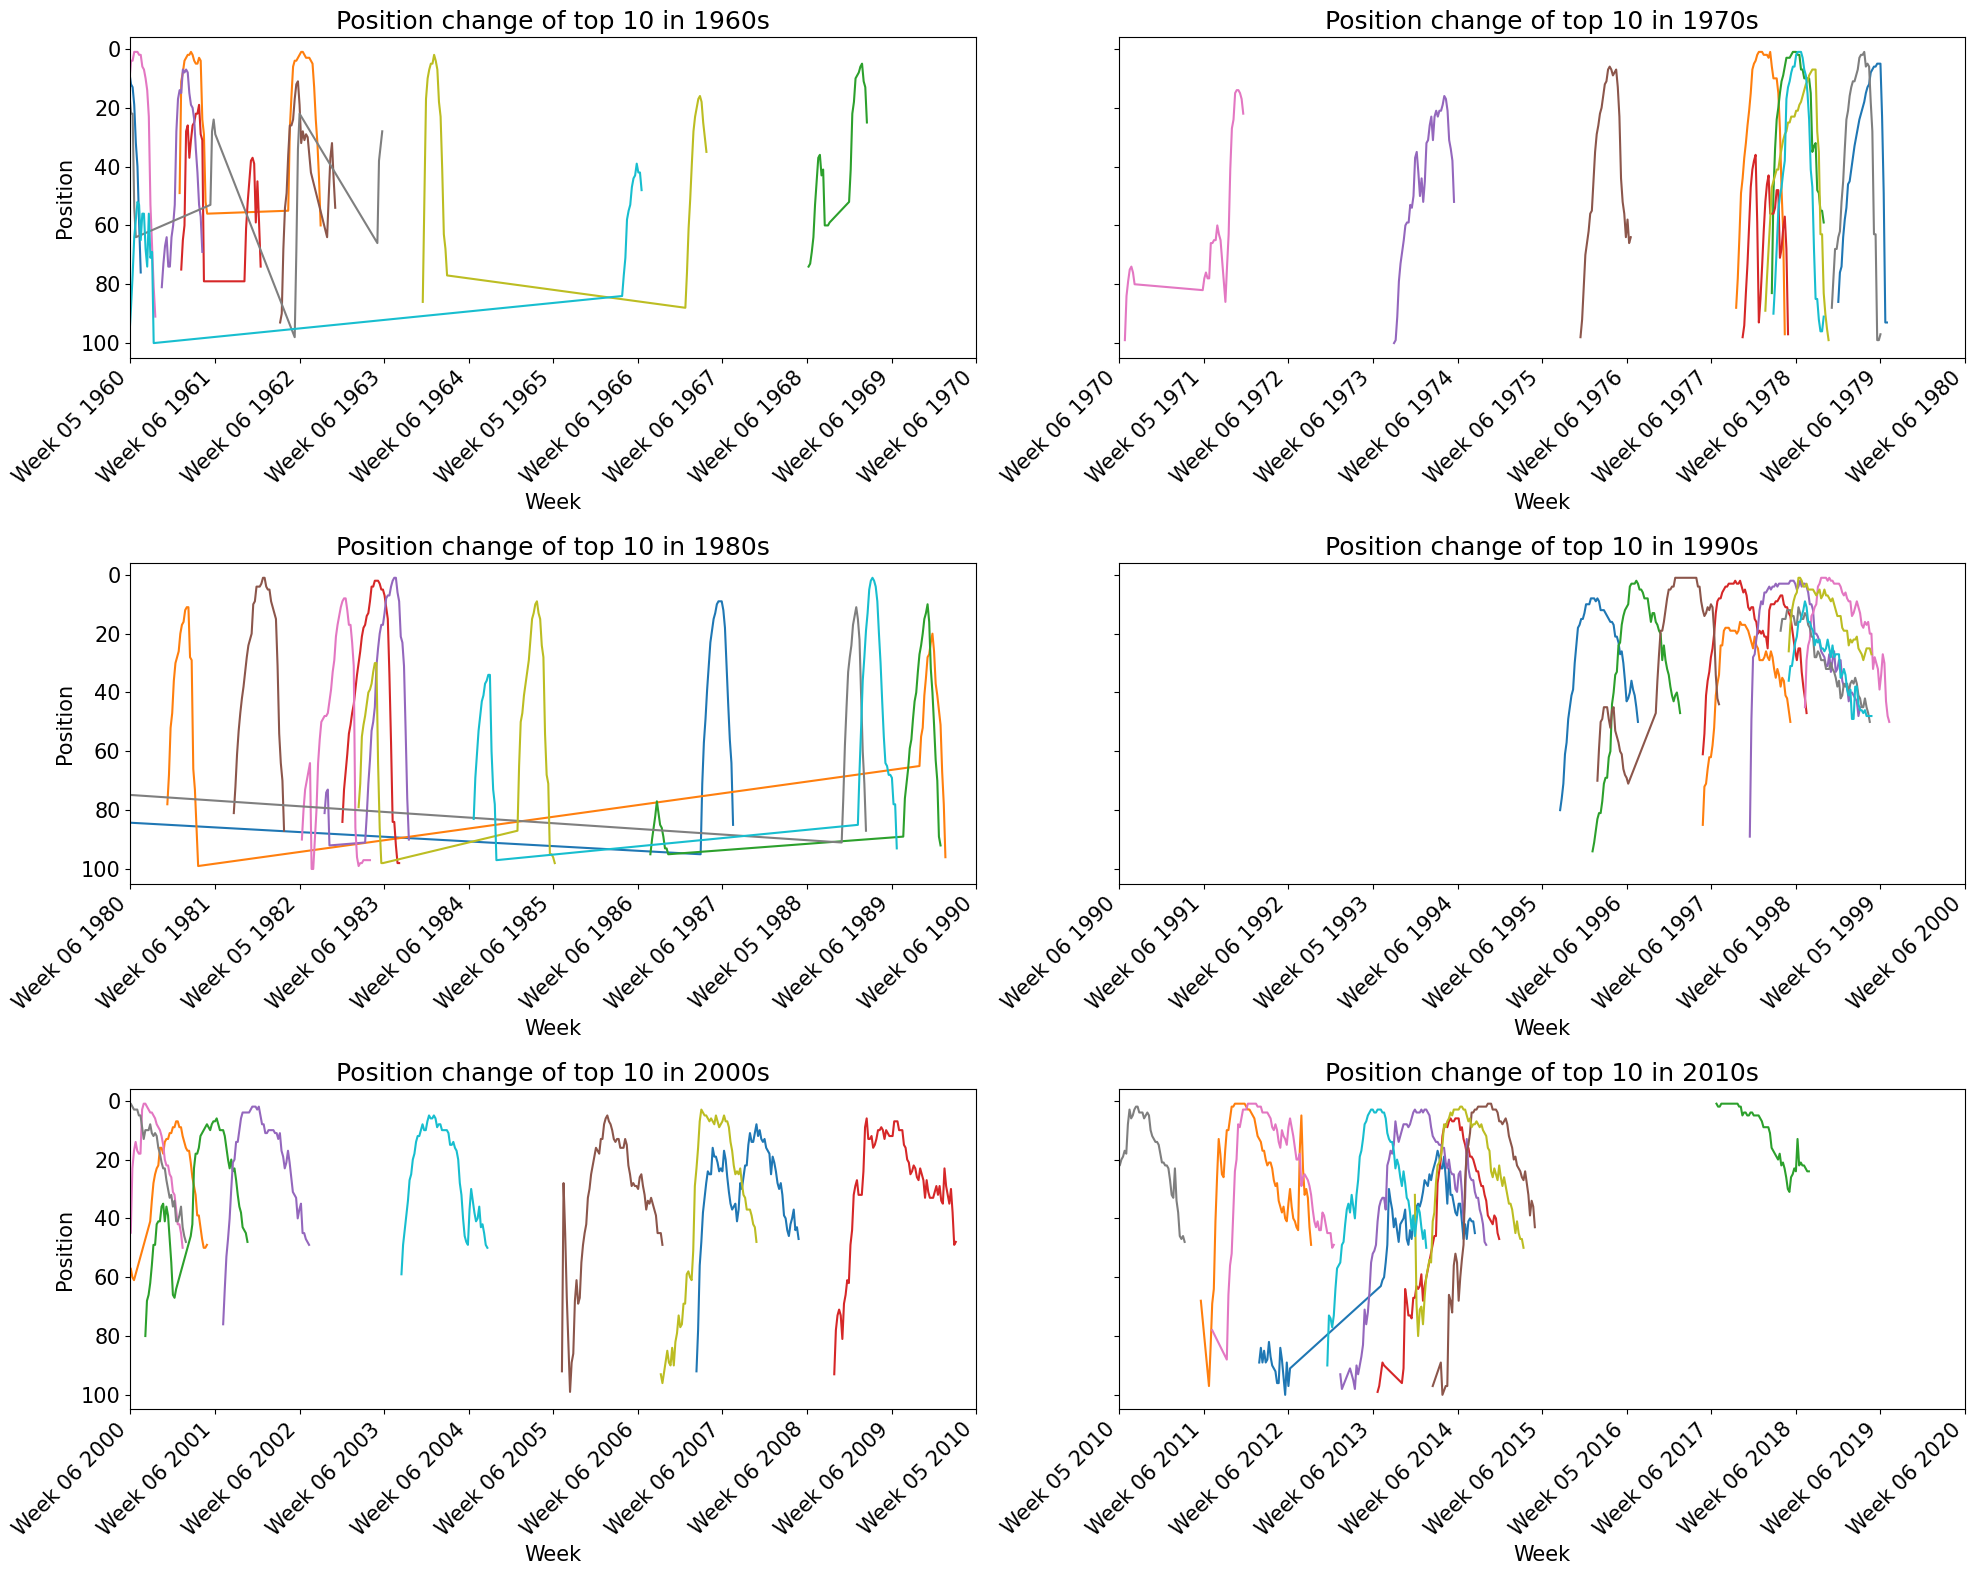

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col = 0
row = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")

    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    top_10_decade_positions.groupby(by=["artist", "song_name"])["position"].plot(
        kind="line", legend=False, rot=0, ax=axes[row, col])

    axes[row, col].set_title(f"Position change of top 10 in {year}s")
    axes[row, col].set_xlabel("Week")
    axes[row, col].set_ylabel("Position")
    axes[row, col].set_xlim([datetime(year, 1, 1), datetime(year + 10, 1, 1)])

    labels = ["Week " + dateutil.parser.parse(item.get_text()).strftime("%V %Y") for item in axes[row, col].get_xticklabels()]
    ticks_loc = axes[row, col].get_xticks().tolist()
    axes[row, col].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row, col].set_xticklabels(labels, rotation=45)

    col += 1
    if col == 2:
        col = 0
        row += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_positions_decades_all_years.pdf", format="pdf")
plt.show()

## Projection trajectory of a song normalized from top 1-10 for decades

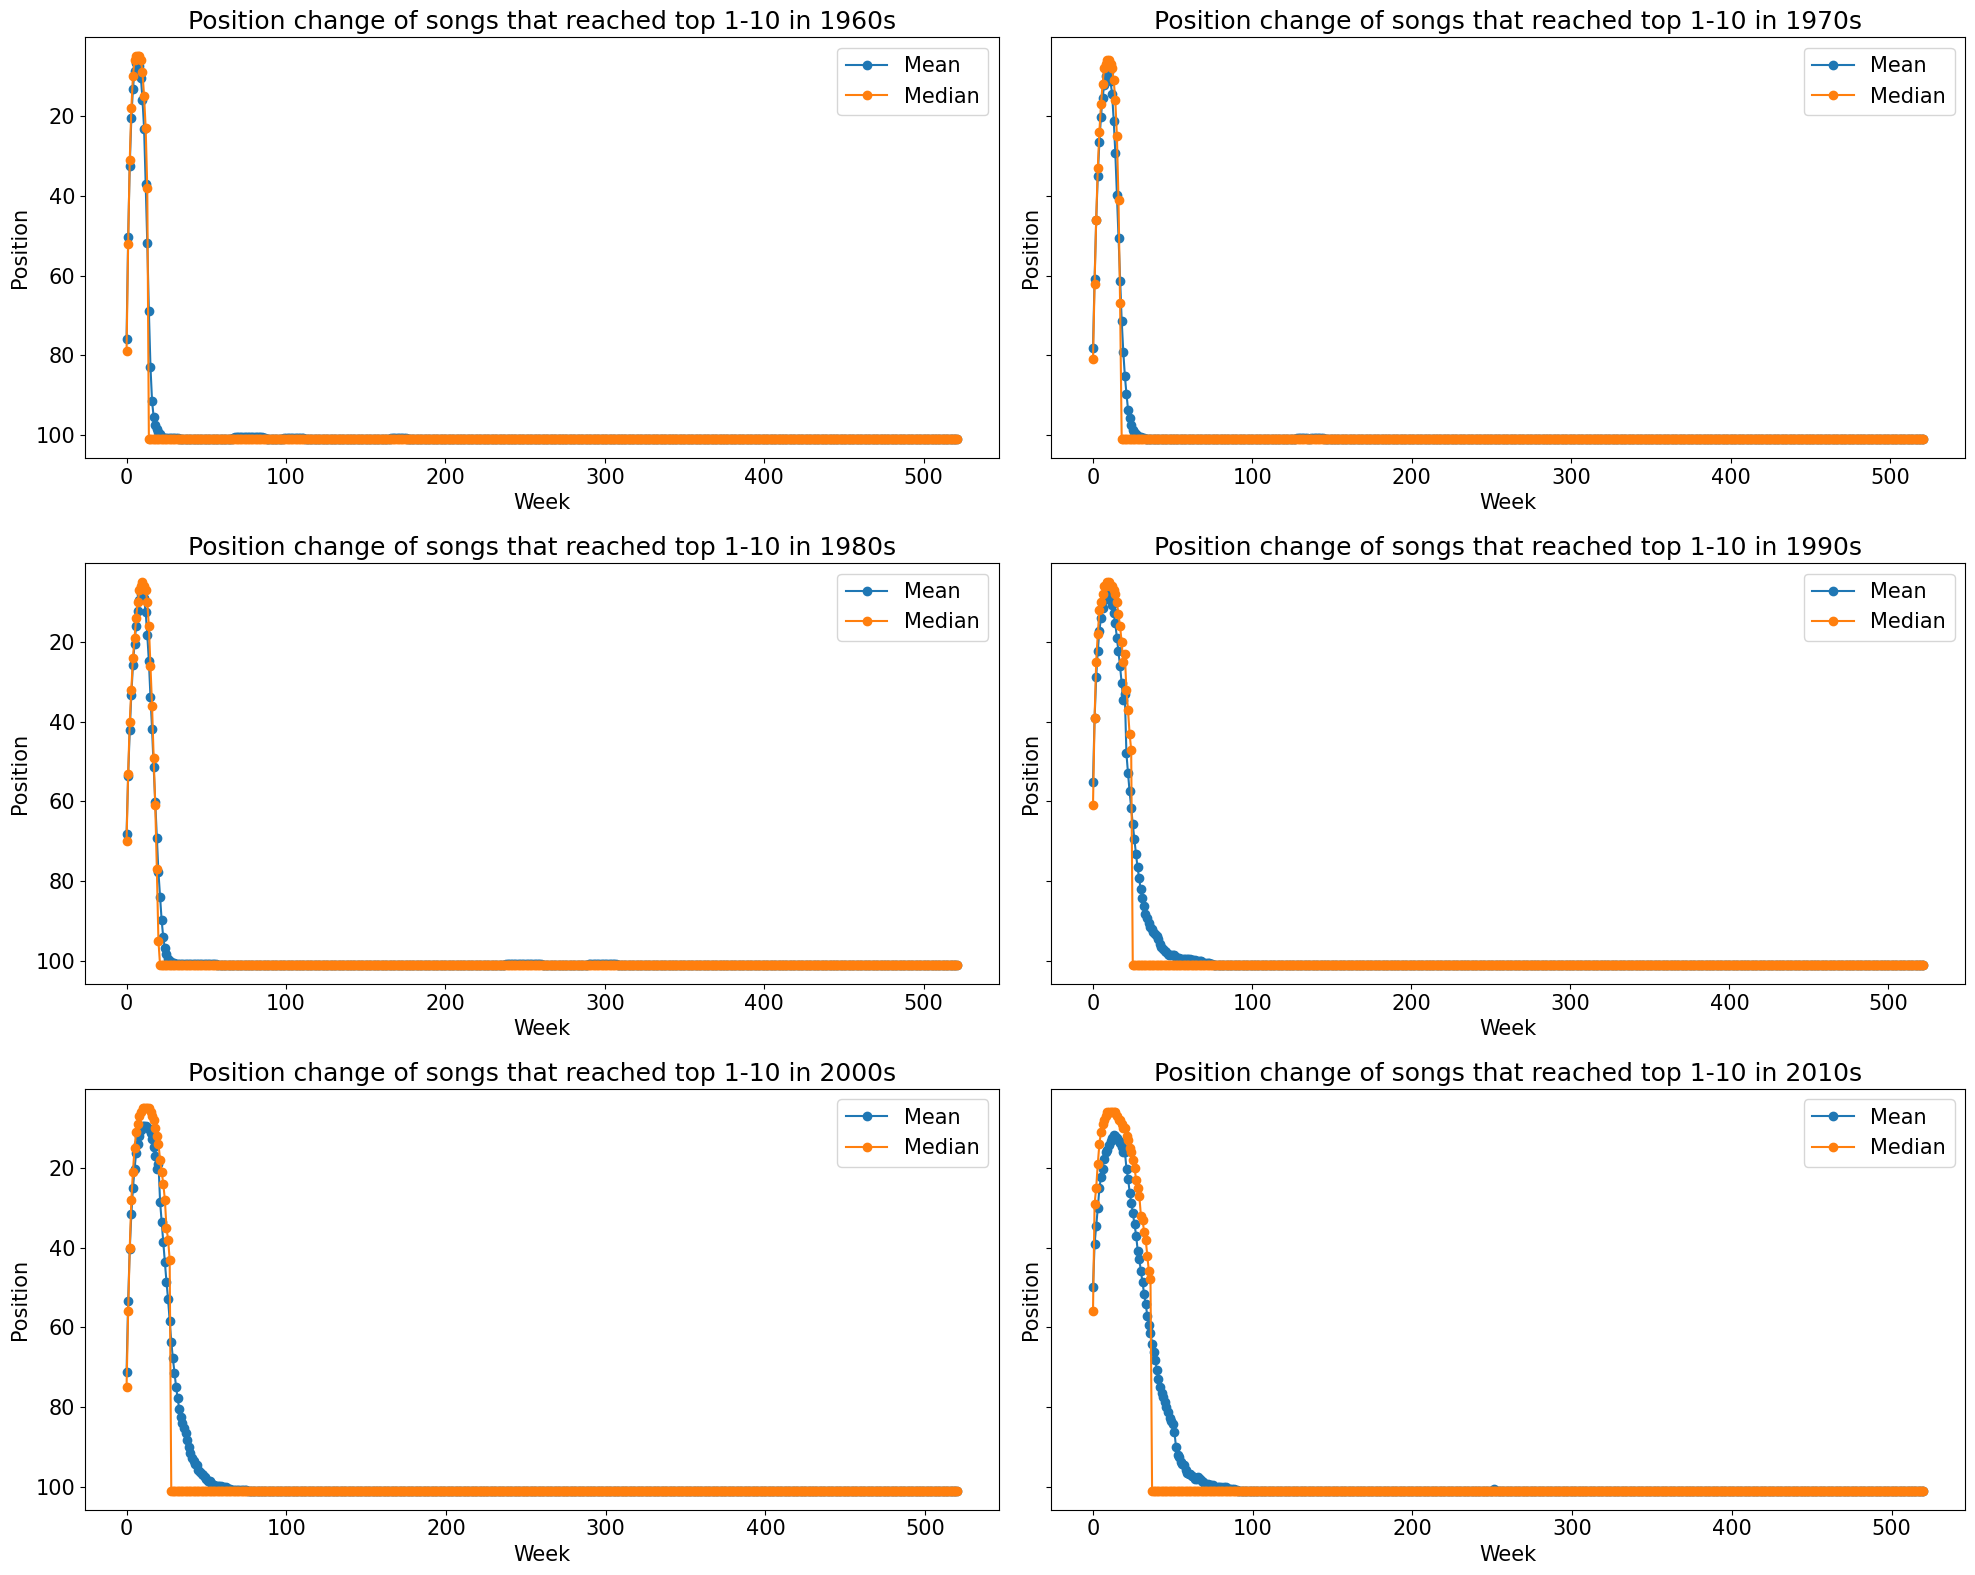

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week"]]

    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[["artist", "song_name", "weeks_on_chart",
            "position", "first_day_of_the_week"]], on=["artist", "song_name"], how="left")

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_positions_in_decade.index.min().to_pydatetime()

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        min_week = group.index.min().to_pydatetime()
        # take only songs from this decade
        if min_week < dateutil.parser.parse(f"{year}-01-01") or max_week > dateutil.parser.parse(f"{year + 9}-12-31"):
            continue
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].set_title(f"Position change of songs that reached top 1-10 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_1_10_positions_normalized_decades.pdf", format="pdf")
plt.show()

### Songs do not start at the same point

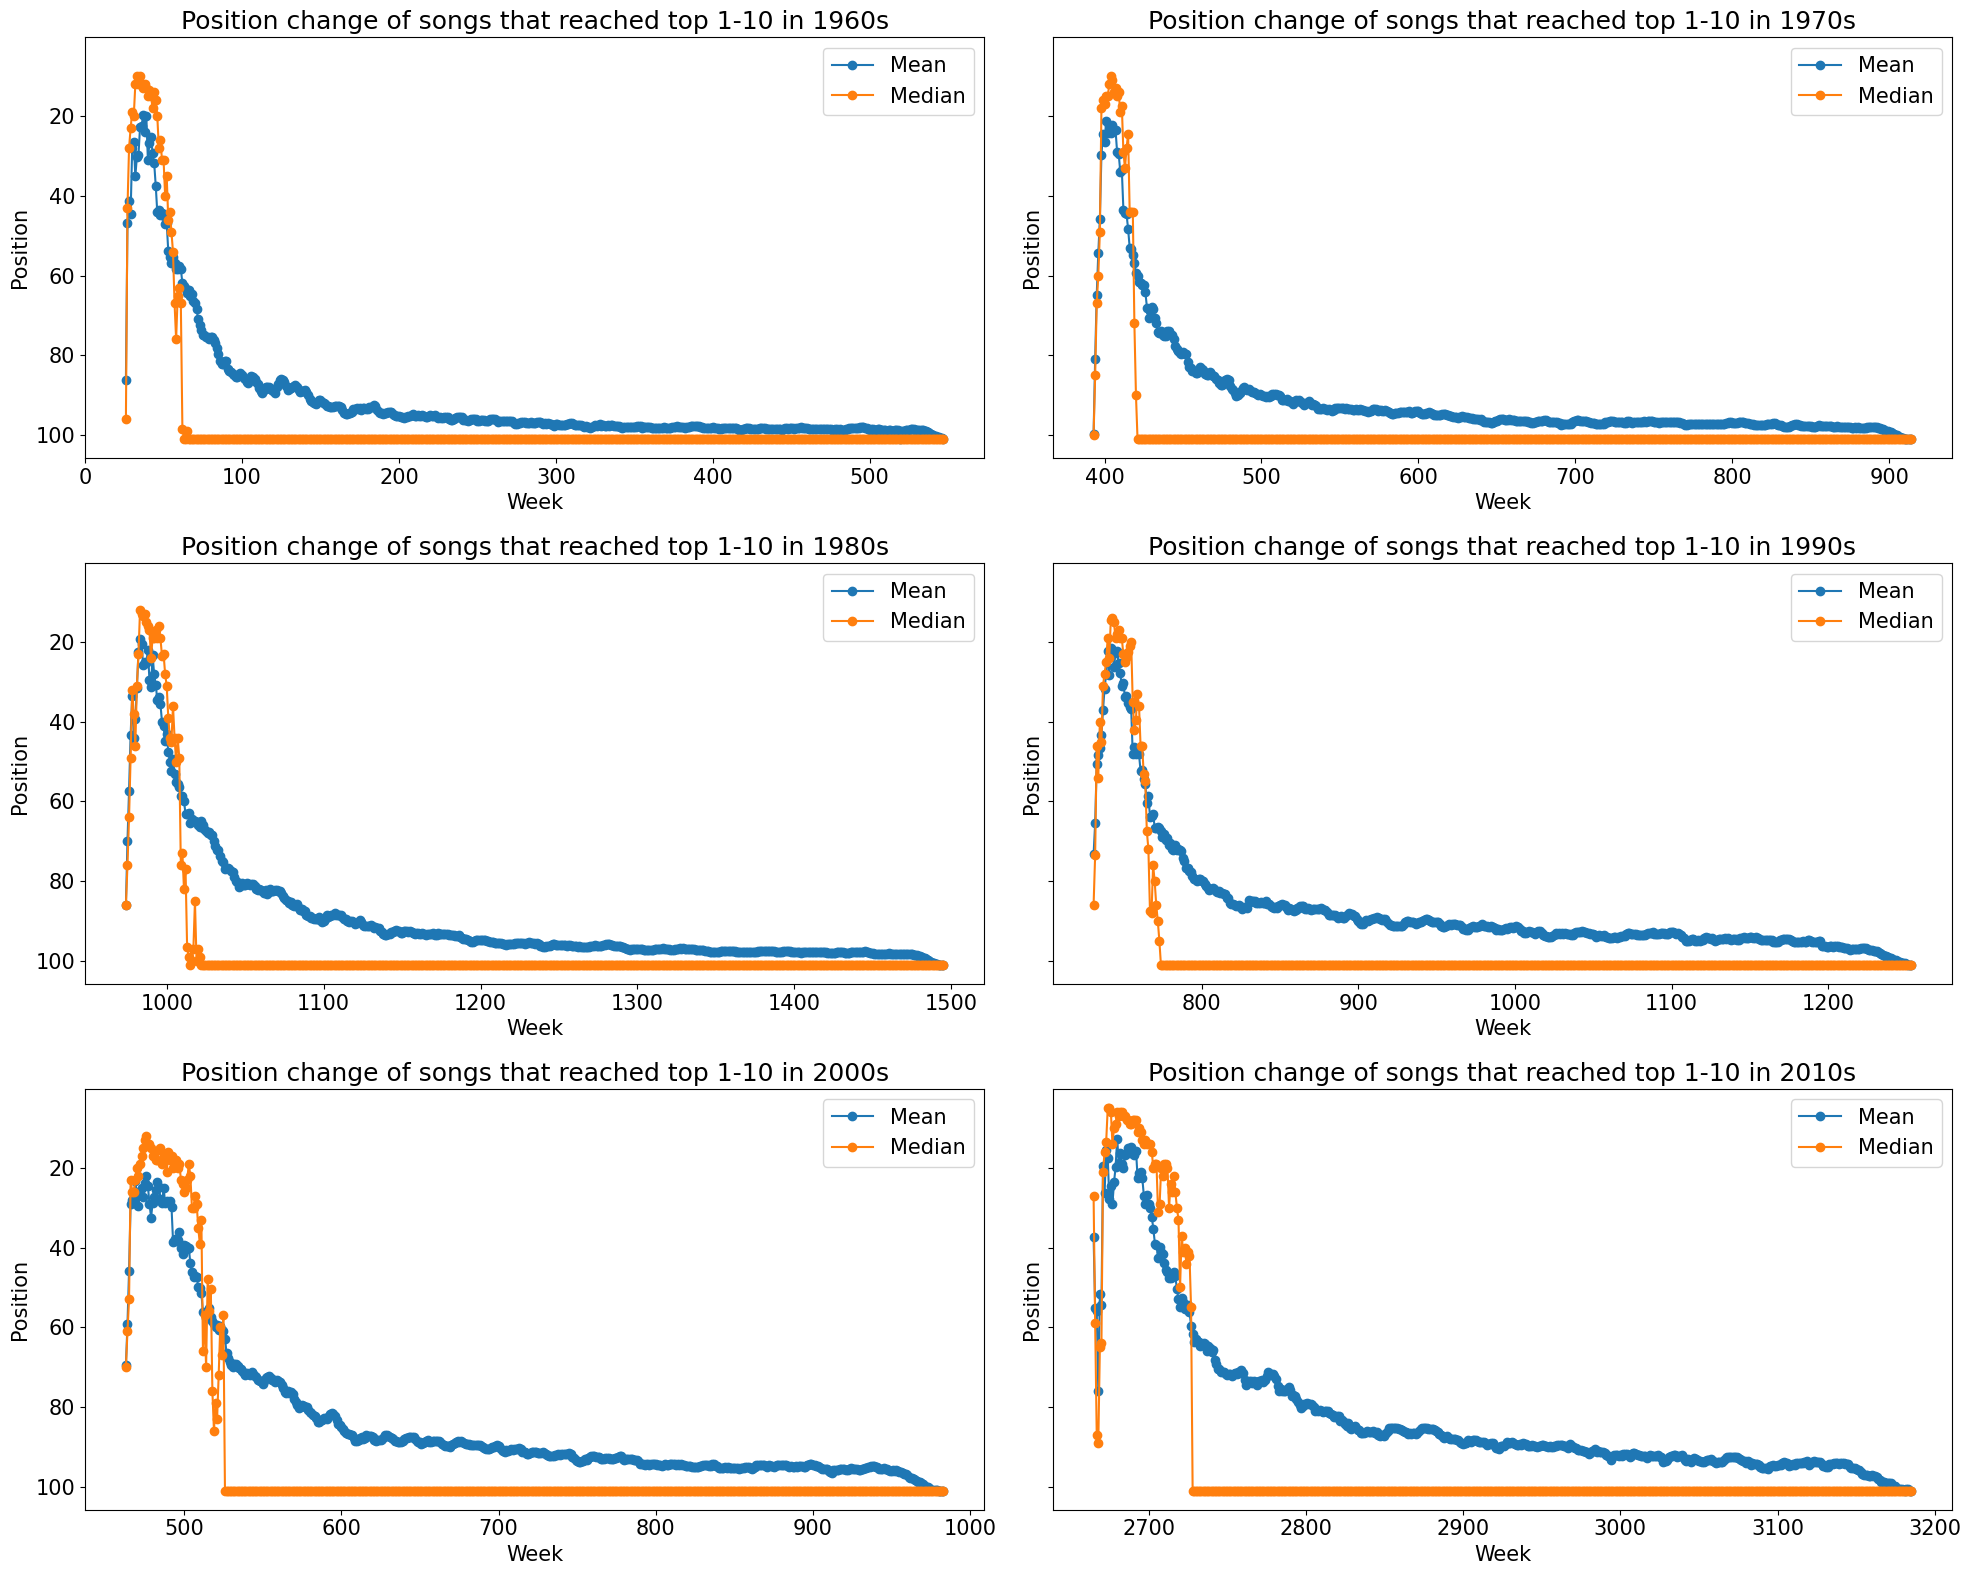

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week"]]

    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[["artist", "song_name", "weeks_on_chart",
            "position", "first_day_of_the_week"]], on=["artist", "song_name"], how="left")

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_positions_in_decade.index.min().to_pydatetime()

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        min_week = group.index.min()
        # take only songs from this decade
        if min_week < dateutil.parser.parse(f"{year}-01-01") or max_week > dateutil.parser.parse(f"{year + 9}-12-31"):
            continue
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index.to_pydatetime() + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int((week_date + timedelta(weeks=1) - min_first_week).days / 7)
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int((row_index - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].set_title(f"Position change of songs that reached top 1-10 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_1_10_positions_with_different_starts_normalized_decades.pdf", format="pdf")
plt.show()

## Taking into account songs that appear in other decades

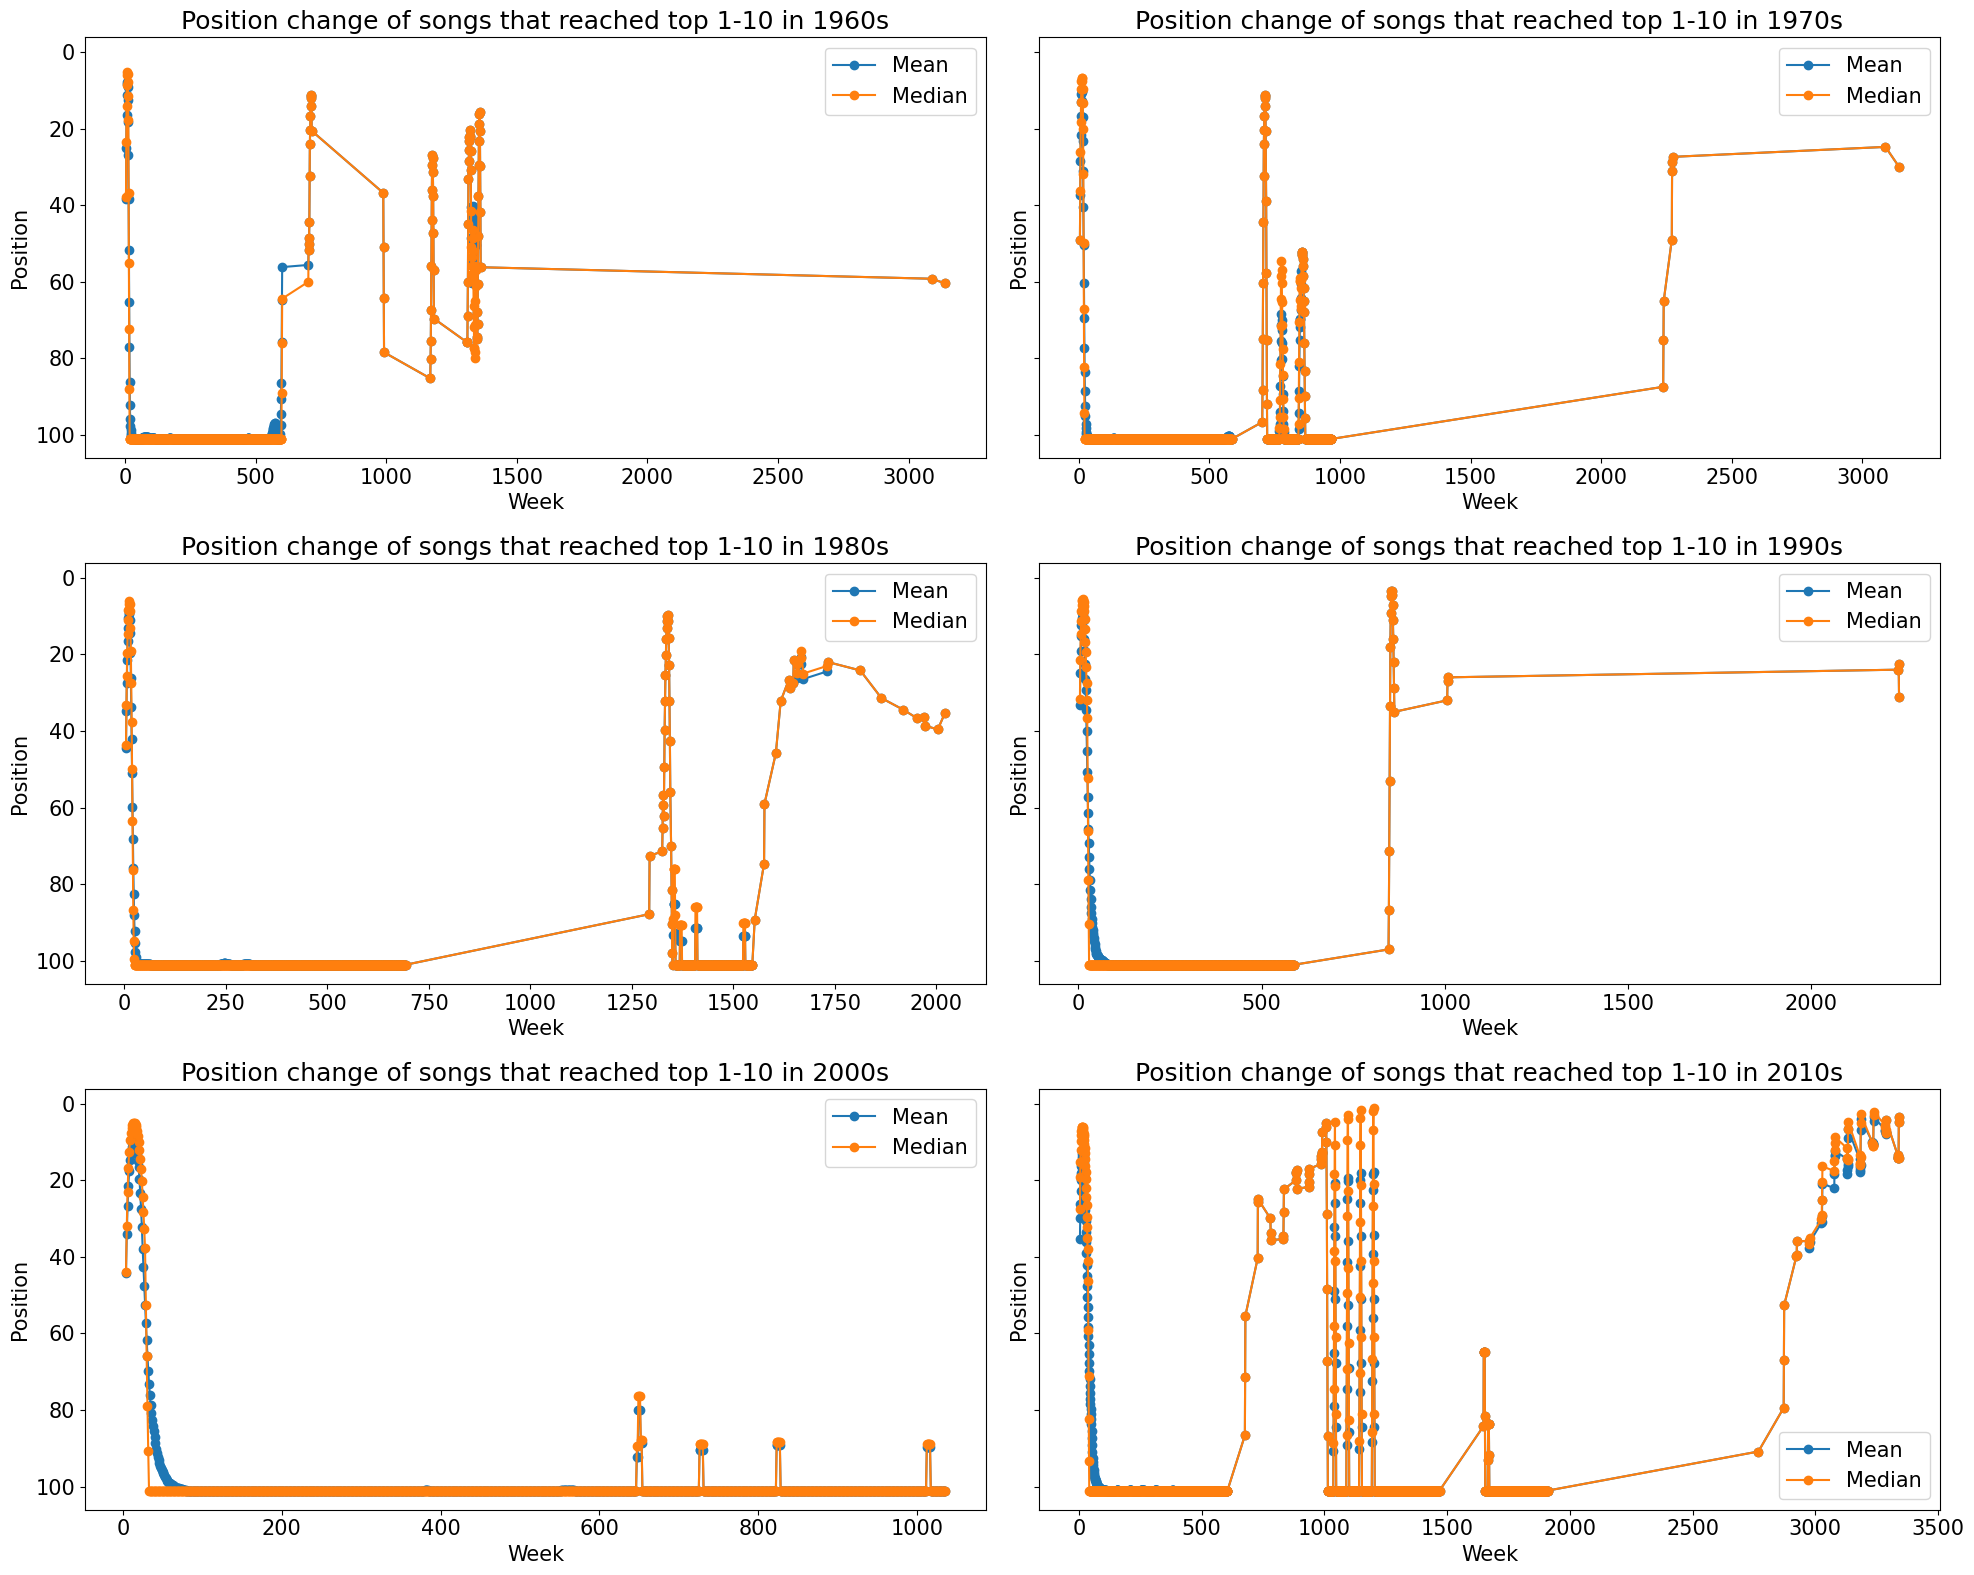

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week"]]

    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[["artist", "song_name", "weeks_on_chart",
            "position", "first_day_of_the_week"]], on=["artist", "song_name"], how="left")

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_positions_in_decade.index.min().to_pydatetime()

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 10}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].set_title(f"Position change of songs that reached top 1-10 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_1_10_positions_normalized_decades_all_years.pdf", format="pdf")
plt.show()

## Projection trajectory of a song normalized from top 10 best performing songs (max weeks on chart) for decades

In [ ]:
# Ben E. King Stand By Me - reappeared on the chart in 1986
# and was created in 1961

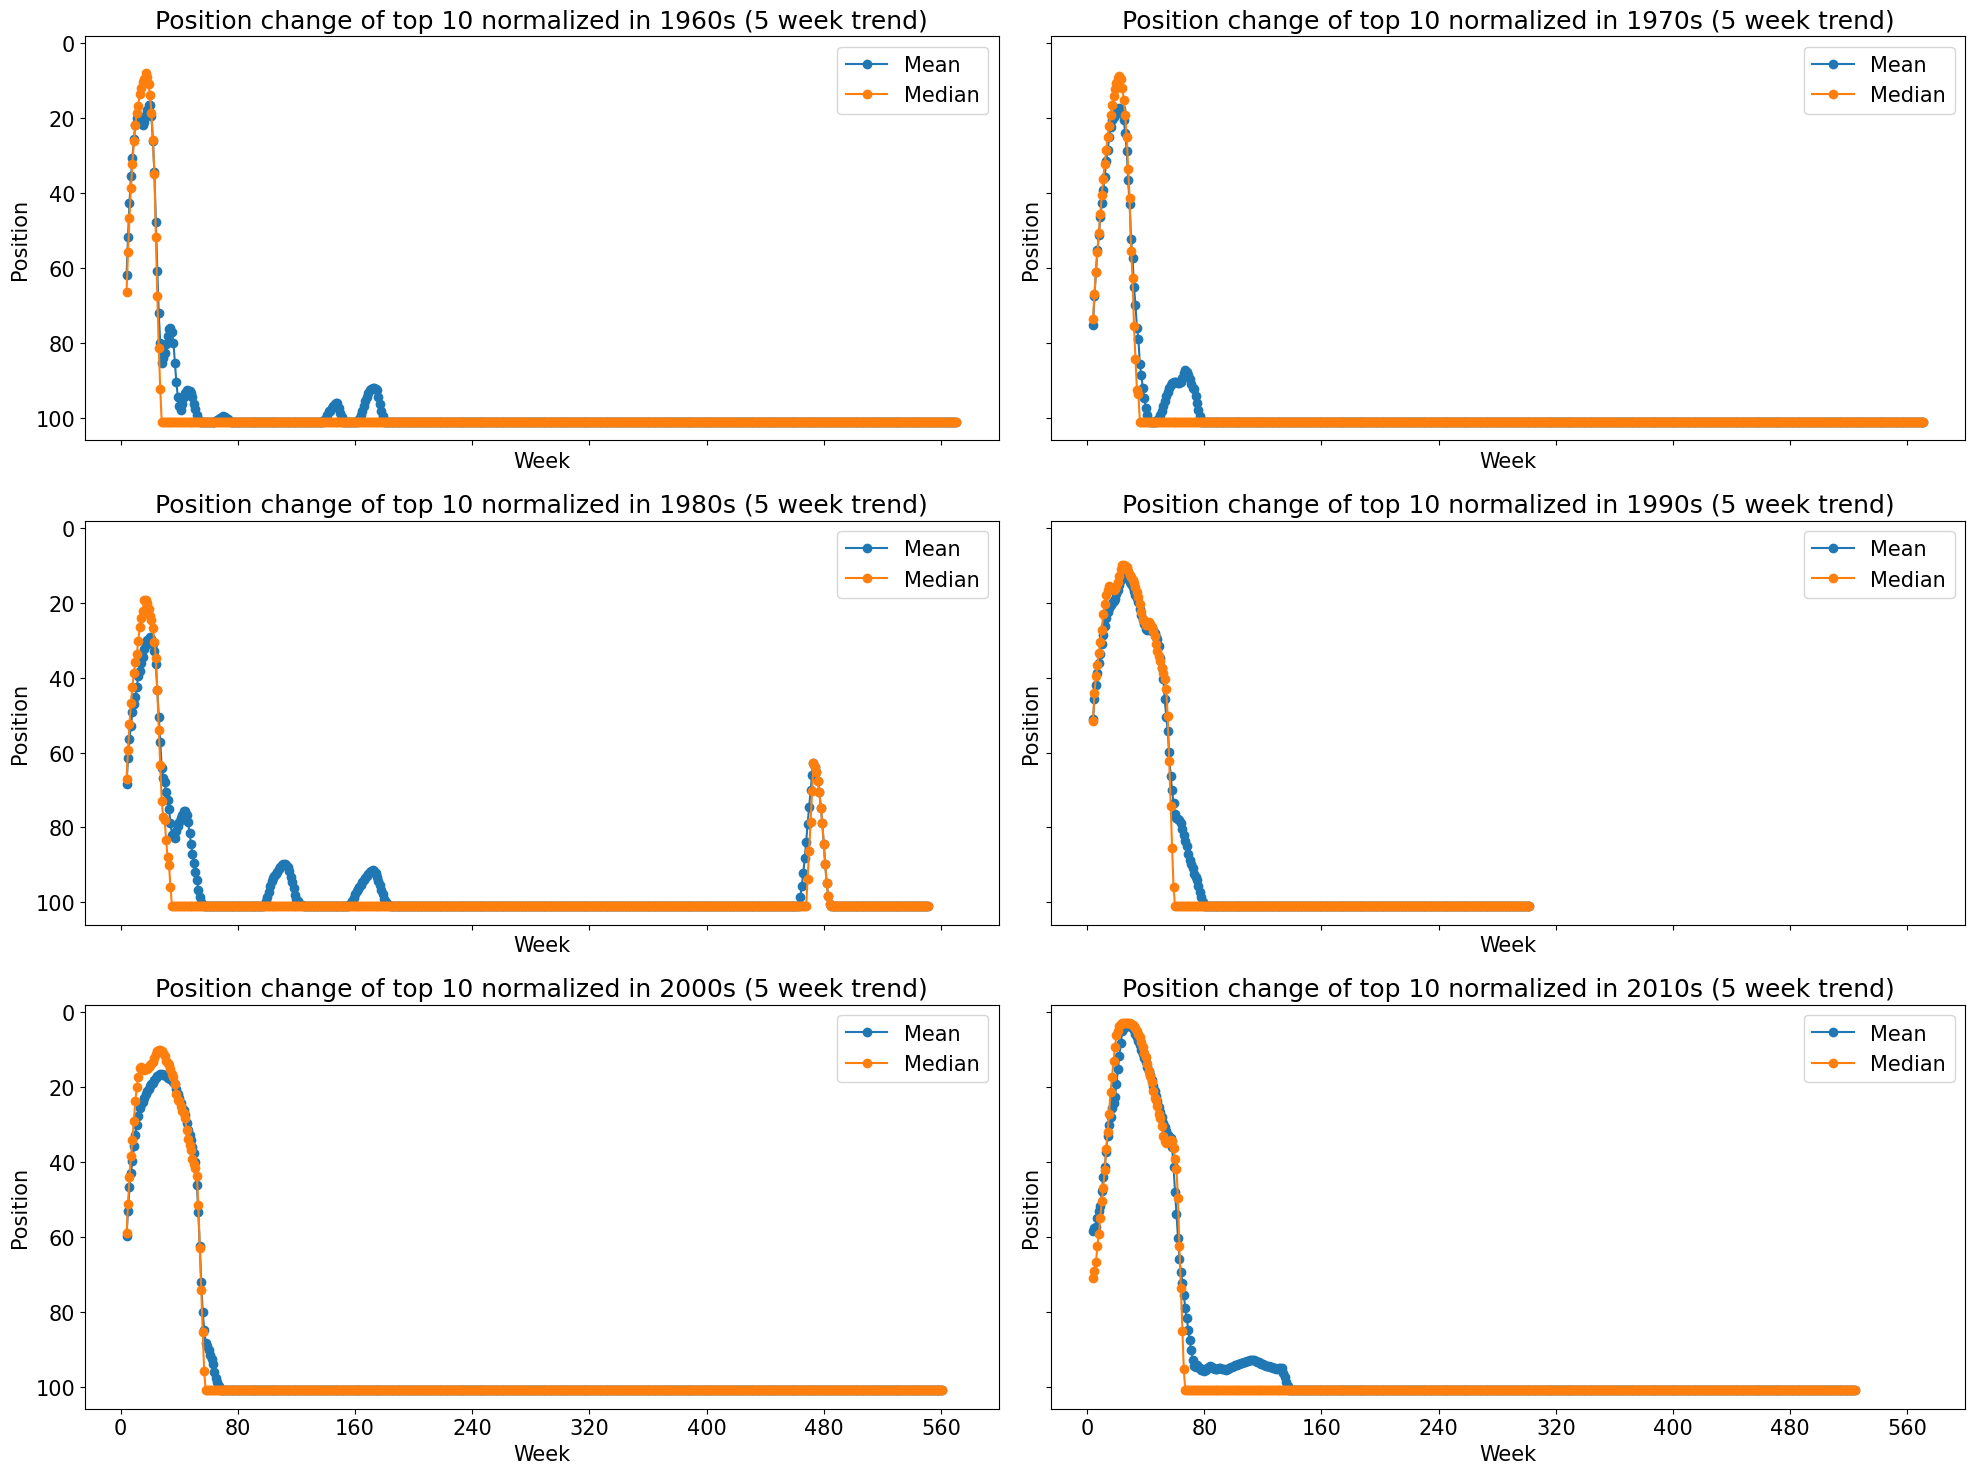

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max().reset_index()
    
    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade[~(max_weeks_on_chart_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            max_weeks_on_chart_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")
    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = top_10_decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 10}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean().rolling(window=5).mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median().rolling(window=5).mean(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of top 10 normalized in {year}s (5 week trend)")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_decade_normalized.pdf", format="pdf")
plt.show()

### Taking into consideration years before and after the decade

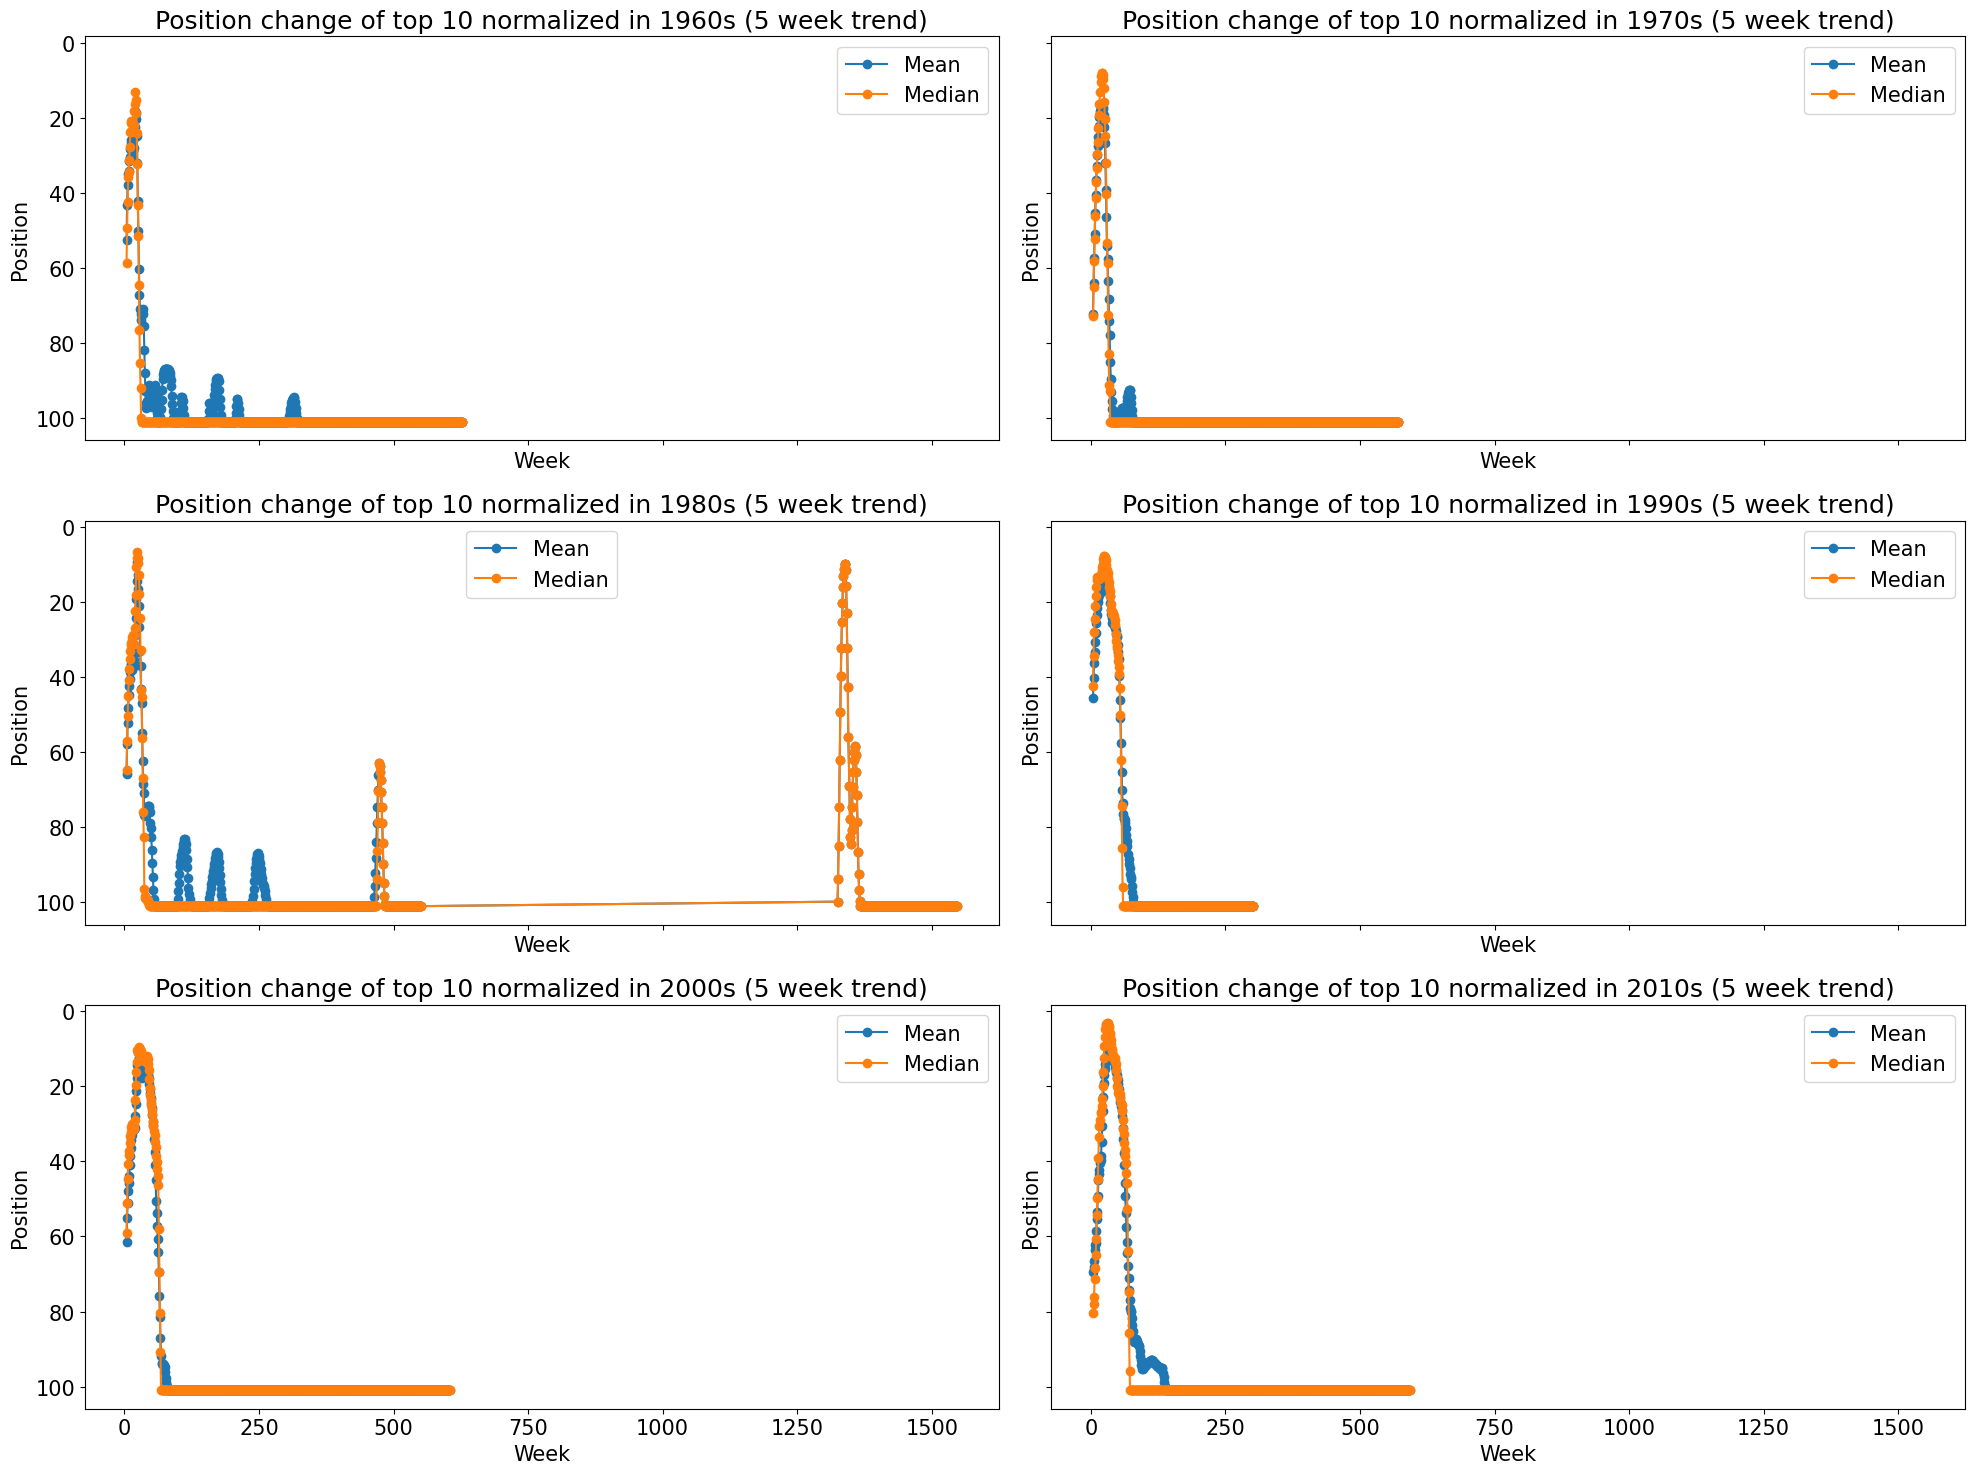

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    max_weeks_on_chart_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]].groupby(
            by=["artist", "song_name"]).max()

    max_weeks_on_chart_in_decade_sorted = max_weeks_on_chart_in_decade.sort_values(
        by="weeks_on_chart", ascending=False).reset_index()

    top_10_in_decade = max_weeks_on_chart_in_decade_sorted.head(10)

    top_10_decade_positions = top_10_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100, on=["artist", "song_name"], how="left")
    top_10_decade_positions.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_decade_positions.index.min().to_pydatetime()

    # subtract first week difference from all first days of the week
    grouped = top_10_decade_positions.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 10}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    top_10_decade_positions_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].mean().rolling(window=5).mean(),
        marker='o')
    axes[row_i, col_i].plot(top_10_decade_positions_normalized.groupby("first_day_of_the_week")["position"].median().rolling(window=5).mean(),
        marker='o')
    
    axes[row_i, col_i].set_title(f"Position change of top 10 normalized in {year}s (5 week trend)")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(8))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/top_10_decade_normalized_all_years.pdf", format="pdf")
plt.show()

## Projection trajectory of a songs that never reached top 50 for decades

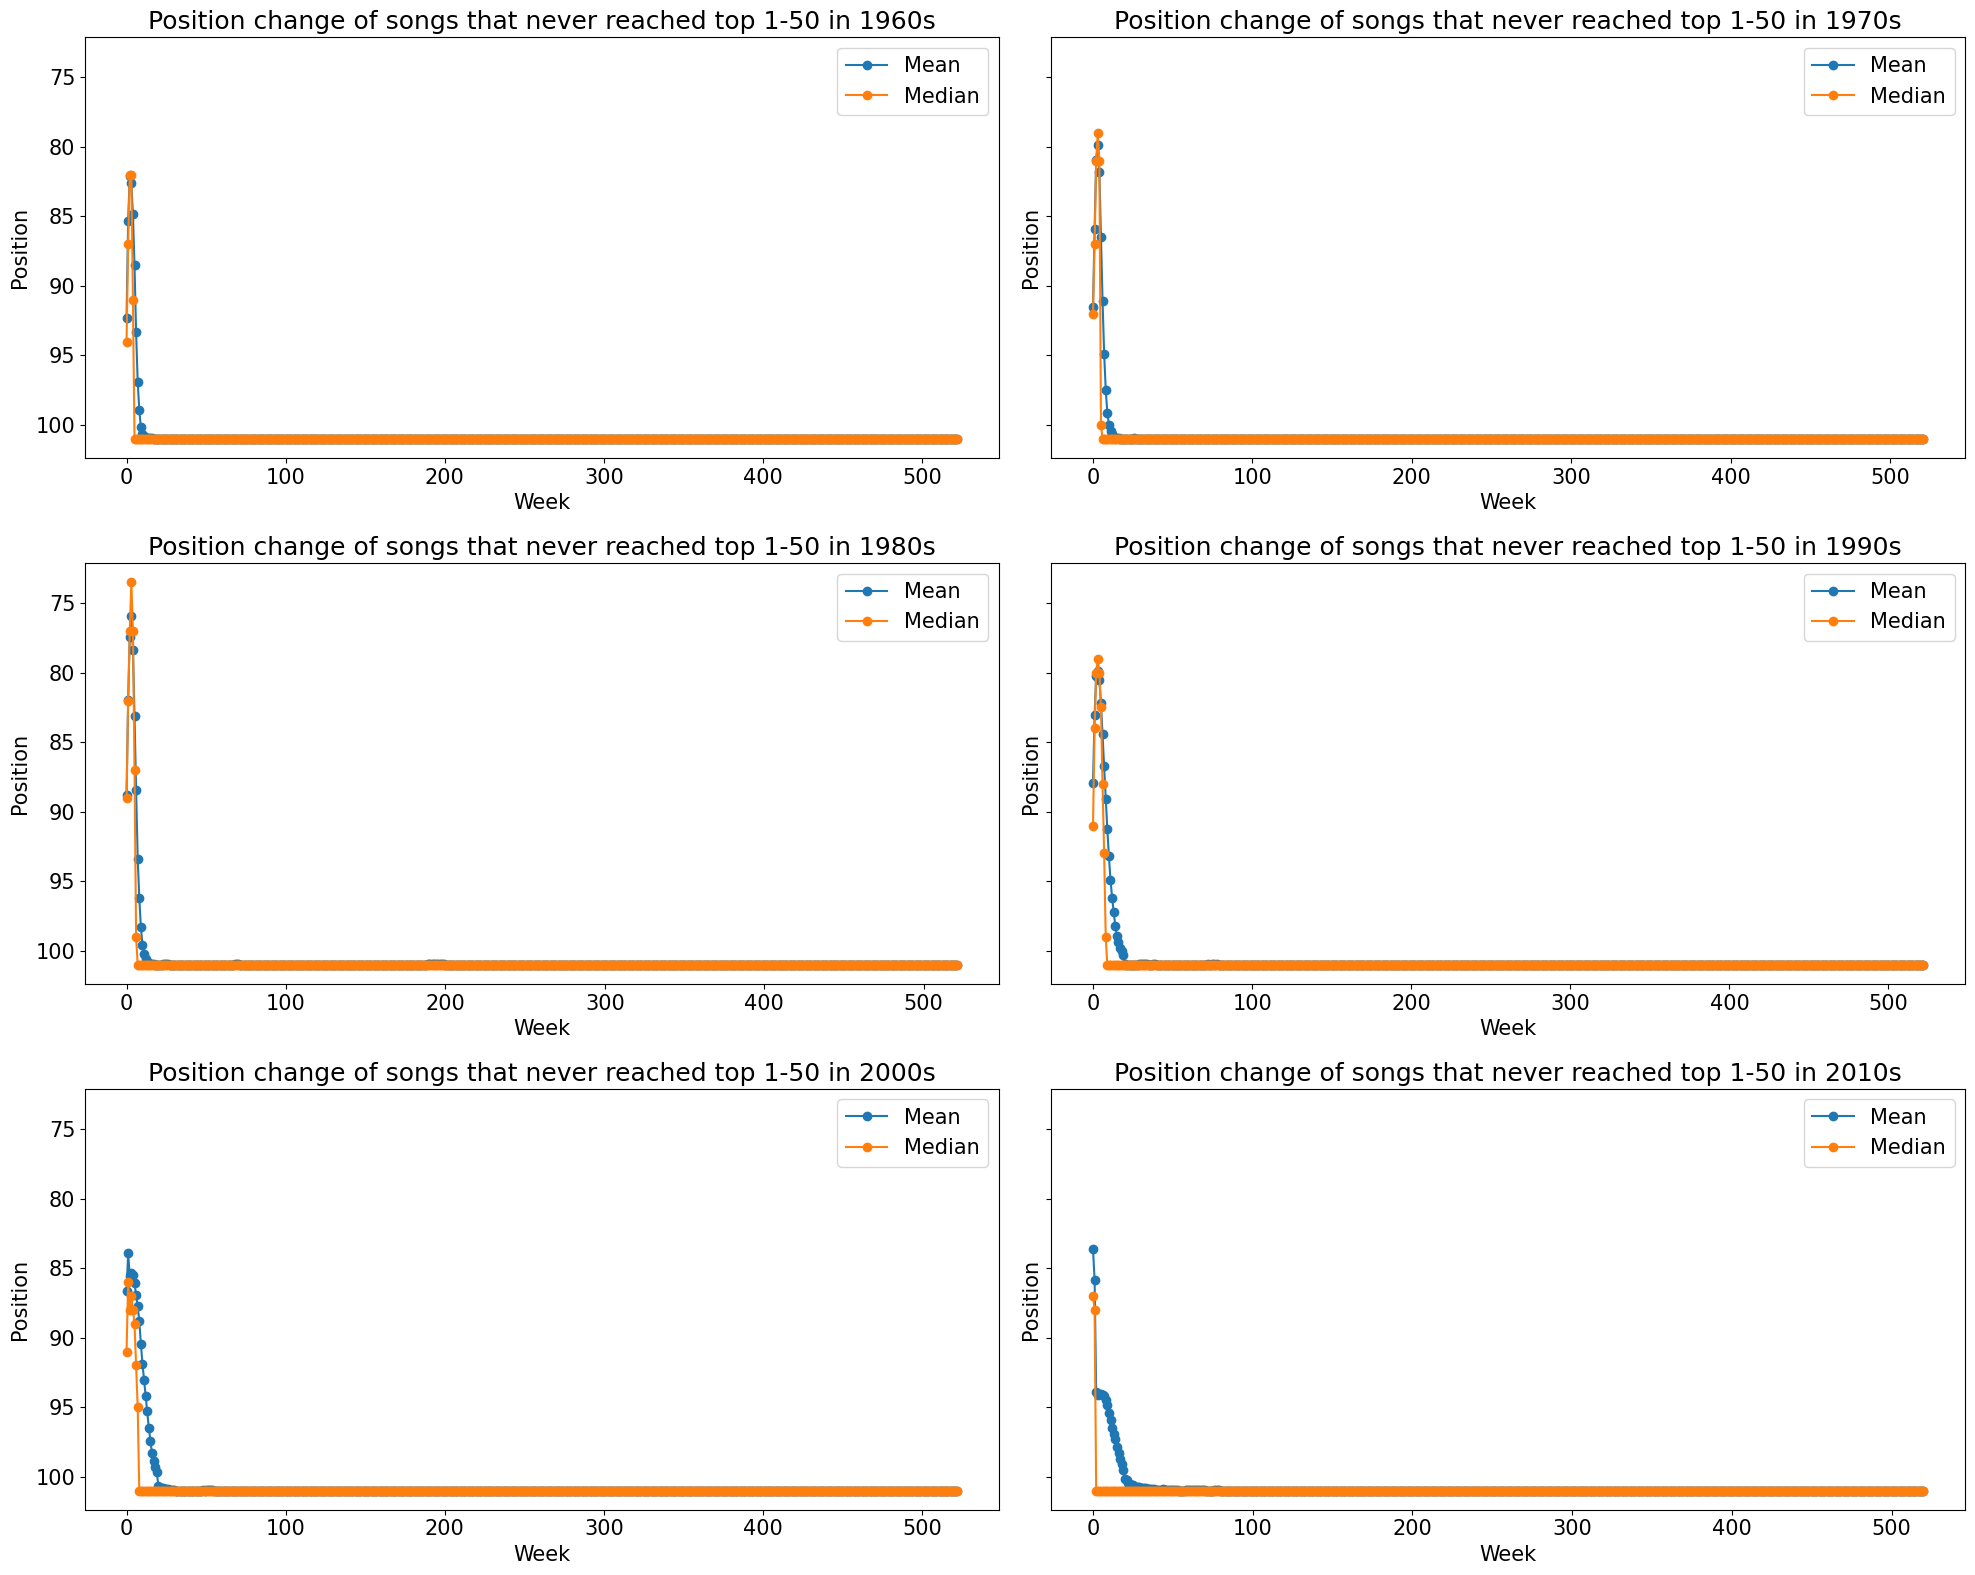

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 50)][["artist", "song_name"]]

    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))]

    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = never_top_10_in_decade.index.min().to_pydatetime()

    grouped = never_top_10_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        min_week = group.index.min().to_pydatetime()
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    never_top_10_in_decade_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(never_top_10_in_decade_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(never_top_10_in_decade_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].set_title(f"Position change of songs that never reached top 1-50 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/never_top_1_50_positions_normalized_decades.pdf", format="pdf")
plt.show()

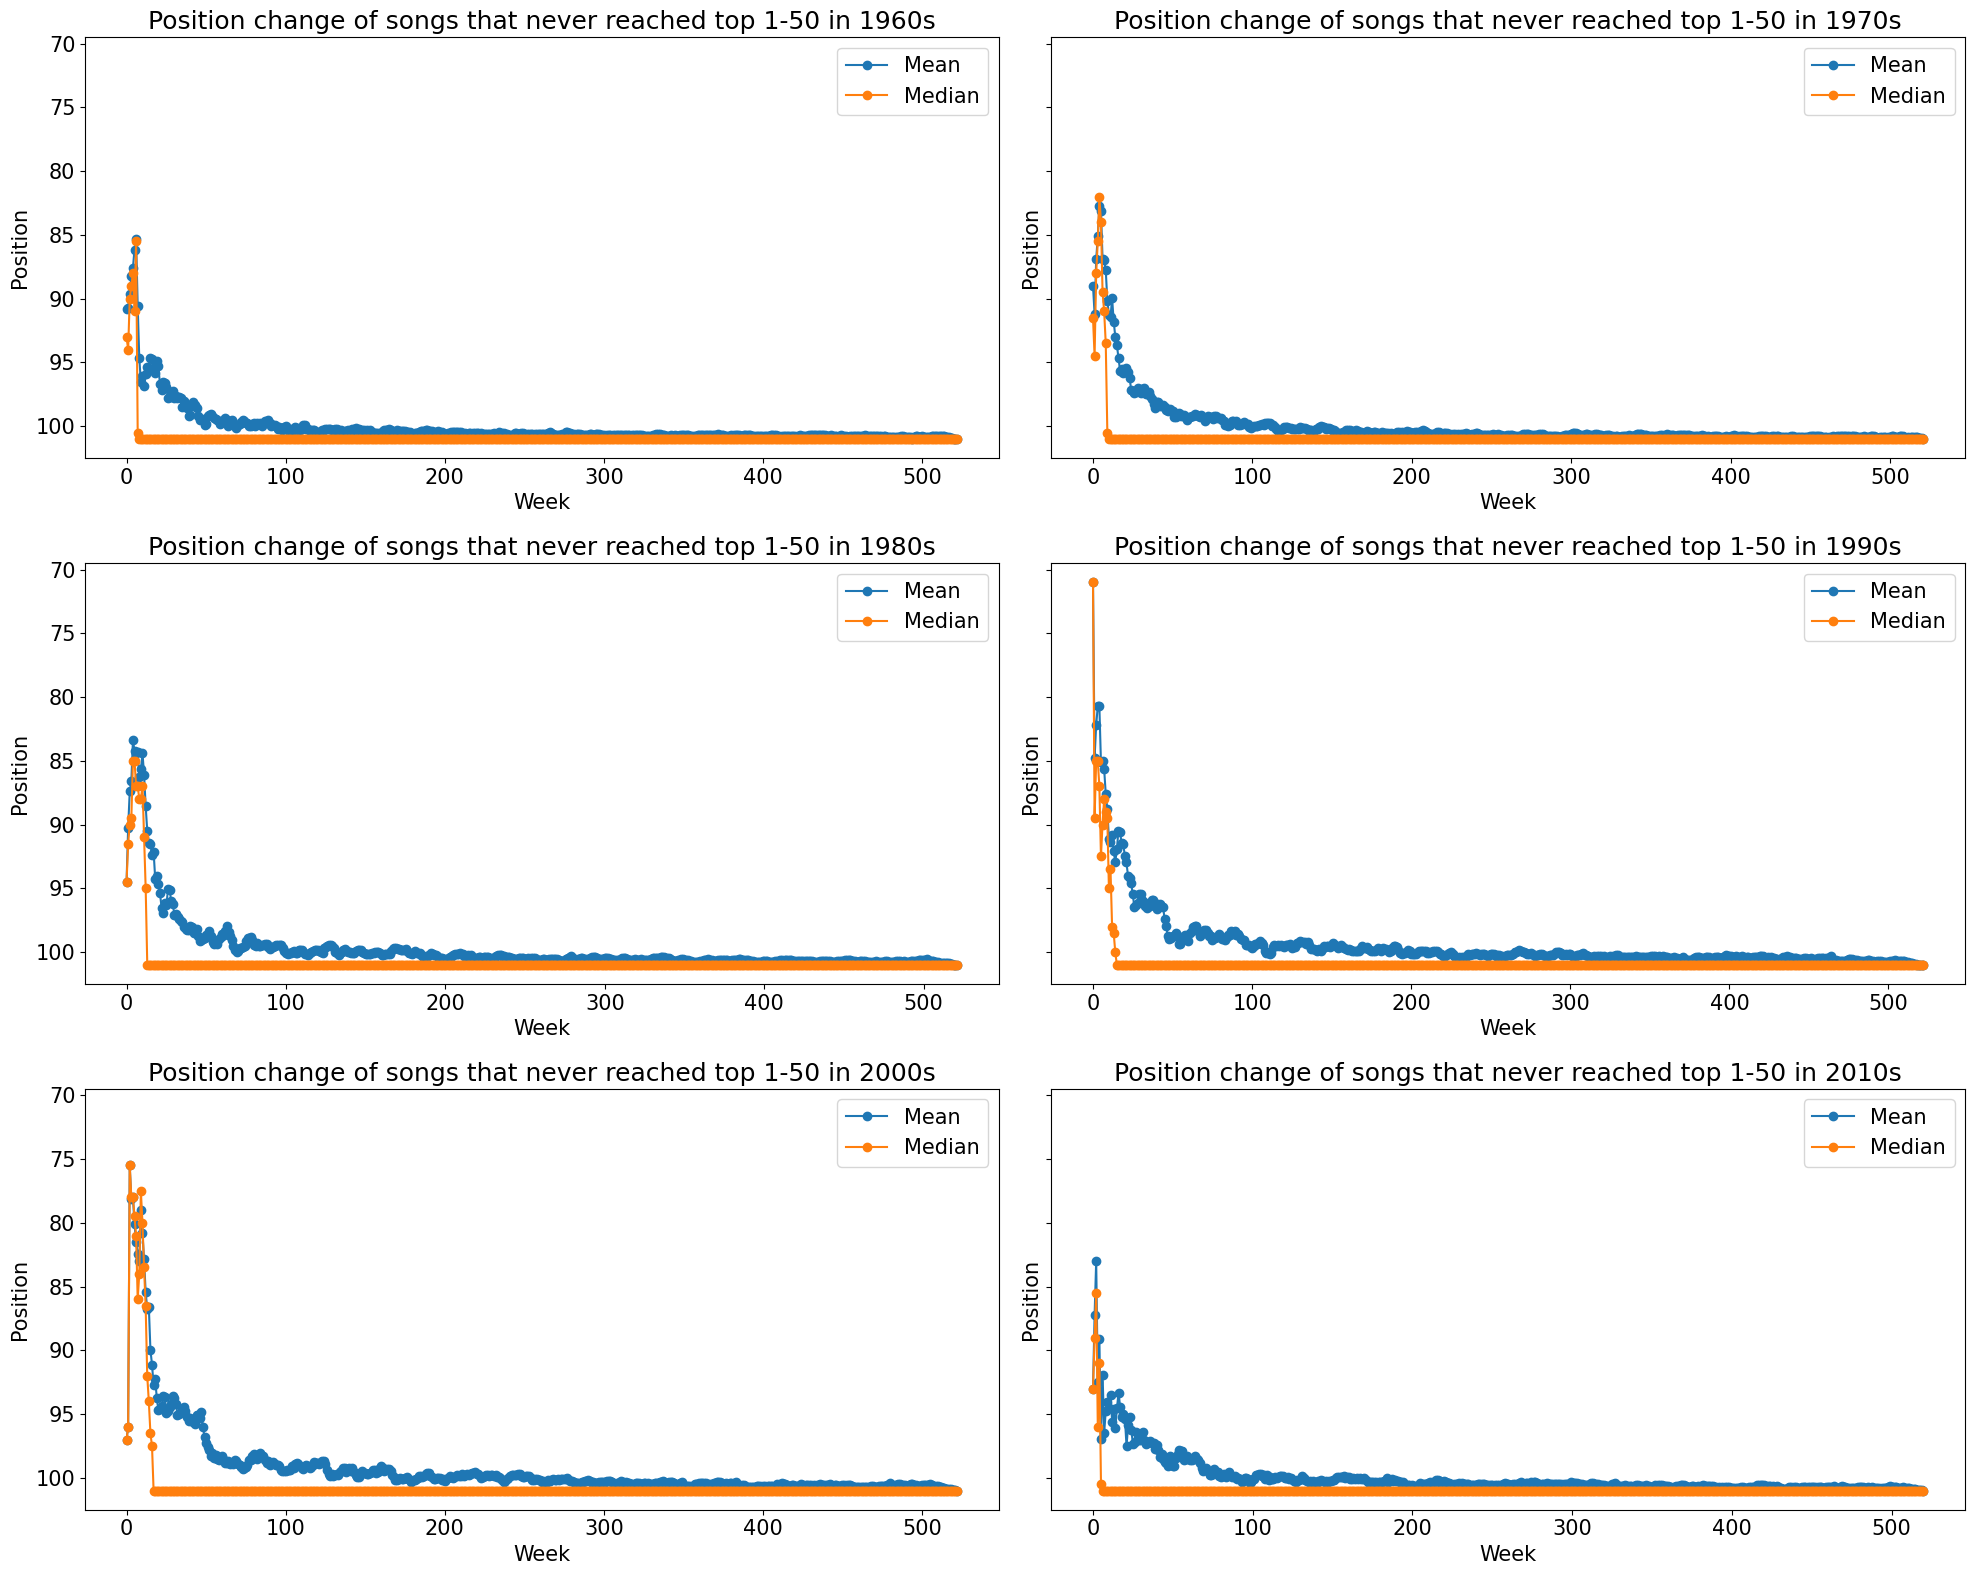

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 50)][["artist", "song_name"]]

    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))]

    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = never_top_10_in_decade.index.min().to_pydatetime()

    grouped = never_top_10_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        min_week = group.index.min()
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index.to_pydatetime() + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "position": 101,
                        "first_day_of_the_week": int((week_date + timedelta(weeks=1) - min_first_week).days / 7)
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int((row_index - min_first_week).days / 7)
            rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })

    never_top_10_in_decade_normalized = pd.DataFrame.from_records(rows_to_add)
    axes[row_i, col_i].plot(never_top_10_in_decade_normalized.groupby("first_day_of_the_week")["position"].mean(),
        marker='o')
    axes[row_i, col_i].plot(never_top_10_in_decade_normalized.groupby("first_day_of_the_week")["position"].median(),
        marker='o')

    axes[row_i, col_i].set_title(f"Position change of songs that never reached top 1-50 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].legend(["Mean", "Median"])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/never_top_1_50_positions_with_different_starts_normalized_decades.pdf", format="pdf")
plt.show()

## Histogram of start and end positions for decades

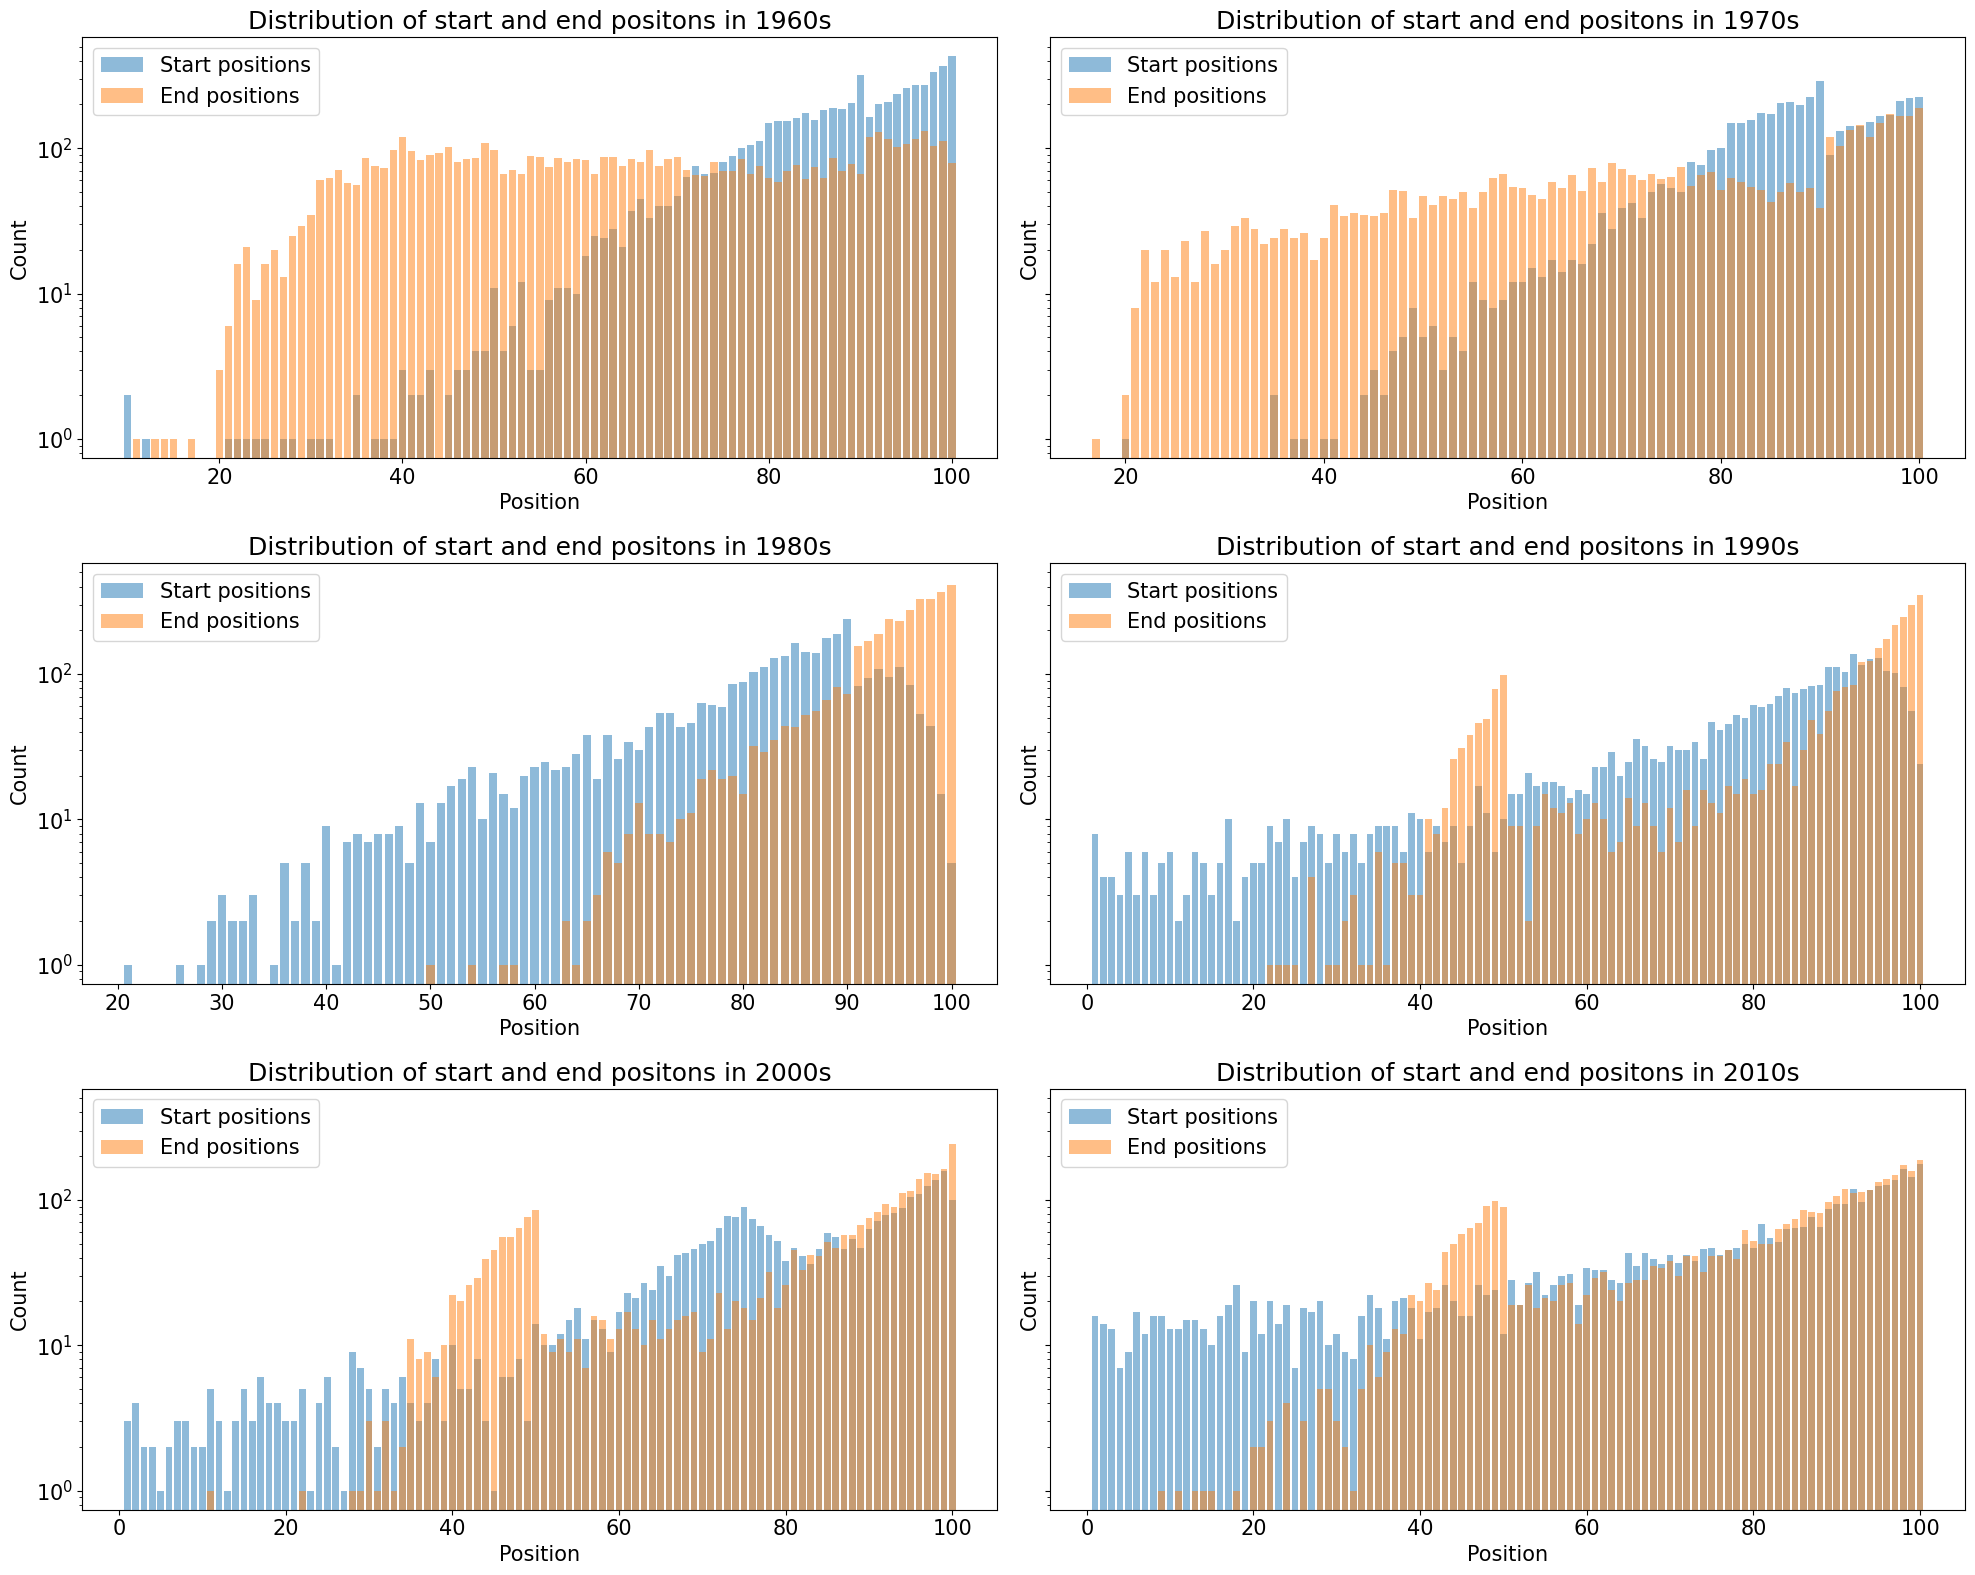

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    songs_from_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]

    start_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].min().reset_index()
    end_weeks = songs_from_decade.groupby(["artist", "song_name"])["first_day_of_the_week"].max().reset_index()

    start_positions = start_weeks.merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]
    end_positions = end_weeks.merge(songs_from_decade, on=["artist", "song_name", "first_day_of_the_week"])["position"]

    count_start_positions = start_positions.value_counts().sort_index()
    count_end_positions = end_positions.value_counts().sort_index()

    axes[row_i, col_i].bar(count_start_positions.index, count_start_positions.values, alpha=0.5)
    axes[row_i, col_i].bar(count_end_positions.index, count_end_positions.values, alpha=0.5)
    
    axes[row_i, col_i].set_title(f"Distribution of start and end positons in {year}s")
    axes[row_i, col_i].set_xlabel("Position")
    axes[row_i, col_i].set_ylabel("Count")
    axes[row_i, col_i].legend(["Start positions", "End positions"])
    axes[row_i, col_i].set_yscale("log")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/distribution_start_end_positions_decades.pdf", format="pdf")
plt.show()

## Max weeks on charts distribution for decades

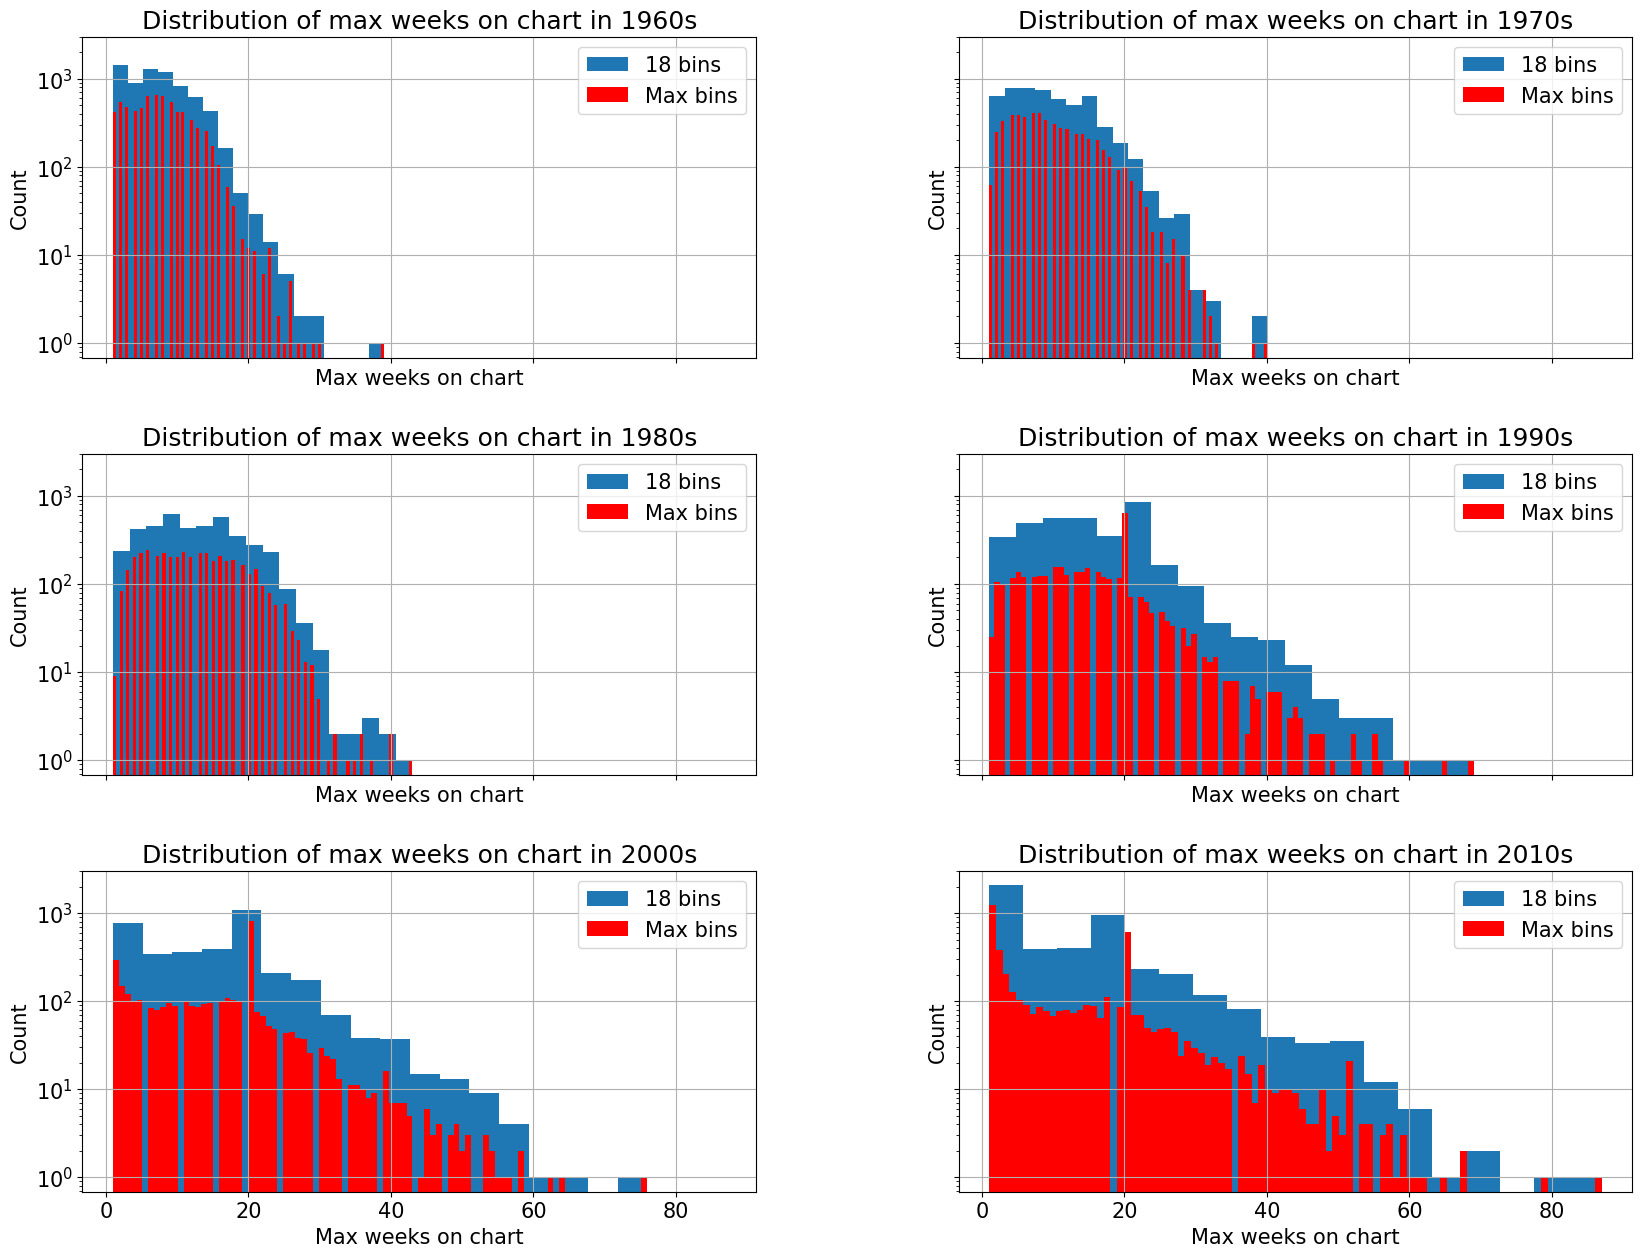

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart.hist(bins=18, figsize=(12, 8), legend=False, ax=axes[row_i, col_i])
    max_weeks_on_chart.hist(bins=billboard_hot_100["weeks_on_chart"].max(), figsize=(12, 8), legend=False, color="red", ax=axes[row_i, col_i])

    axes[row_i, col_i].set_title(f"Distribution of max weeks on chart in {year}s")
    axes[row_i, col_i].set_xlabel("Max weeks on chart")
    axes[row_i, col_i].set_ylabel("Count")
    axes[row_i, col_i].legend(["18 bins", "Max bins"])
    axes[row_i, col_i].set_yscale("log")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/max_weeks_on_chart_distribution_decades.pdf", format="pdf")
plt.show()


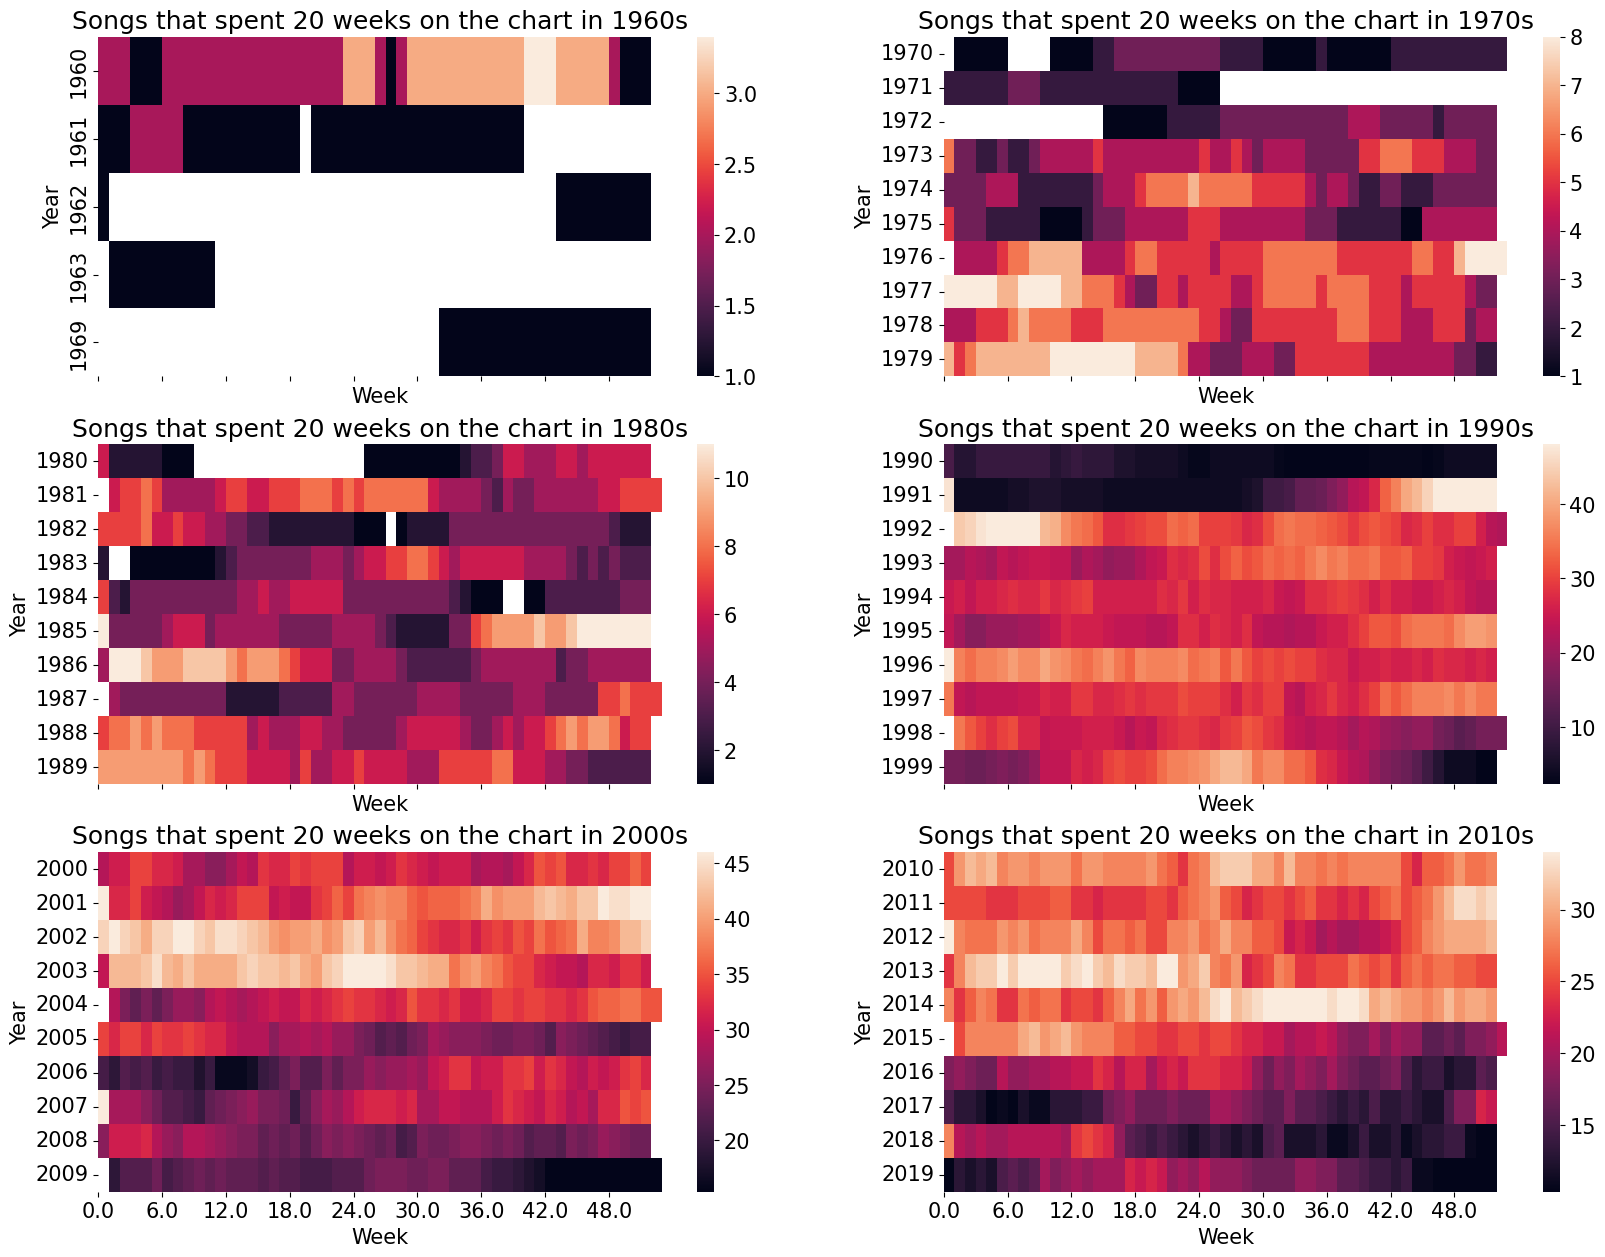

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    max_weeks_on_chart = all_songs_in_decade[["artist", "song_name", "weeks_on_chart"]].groupby(
        by=["artist", "song_name"]).max().reset_index()

    max_weeks_on_chart_20 = max_weeks_on_chart[max_weeks_on_chart["weeks_on_chart"] == 20]

    max_weeks_on_chart_20_df = max_weeks_on_chart_20[["artist", "song_name"]].merge(
        billboard_hot_100[(billboard_hot_100["year"] >= year) &\
            (billboard_hot_100["year"] < year + 10)], on=["artist", "song_name"], how="left")

    sns.heatmap(max_weeks_on_chart_20_df[["year", "week"]].value_counts().unstack(),
        ax=axes[row_i, col_i], cmap=sns.color_palette("rocket", as_cmap=True), robust=True)
    axes[row_i, col_i].set_title(f"Songs that spent 20 weeks on the chart in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Year")

    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(10))
    ticks_loc = axes[row_i, col_i].get_xticks().tolist()
    axes[row_i, col_i].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    axes[row_i, col_i].set_xticklabels(axes[row_i, col_i].get_xticks(), rotation = 0)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/heatmap_20_weeks_on_chart_decades.pdf", format="pdf")
plt.show()


## New songs on charts for decades

In [ ]:
# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# MTV Launch date
mtv_launch_date = pd.to_datetime("1981-08-01", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

important_dates_names = {2008: "Spotify release", 2005: "Youtube release", 2015: "Apple Music release",
                         1981: "MTV launch", 1982: "CDs release", 1991: "MP3 release"}
important_dates = {2008: (spotify_creation_date, "green"), 2005: (youtube_creation_date, "red"), 2015: (apple_music_creation_date, "pink"),
                   1981: (mtv_launch_date, "black"), 1982: (cds_creation_date, "turquoise"), 1991: (mp3_creation_date, "yellow")}

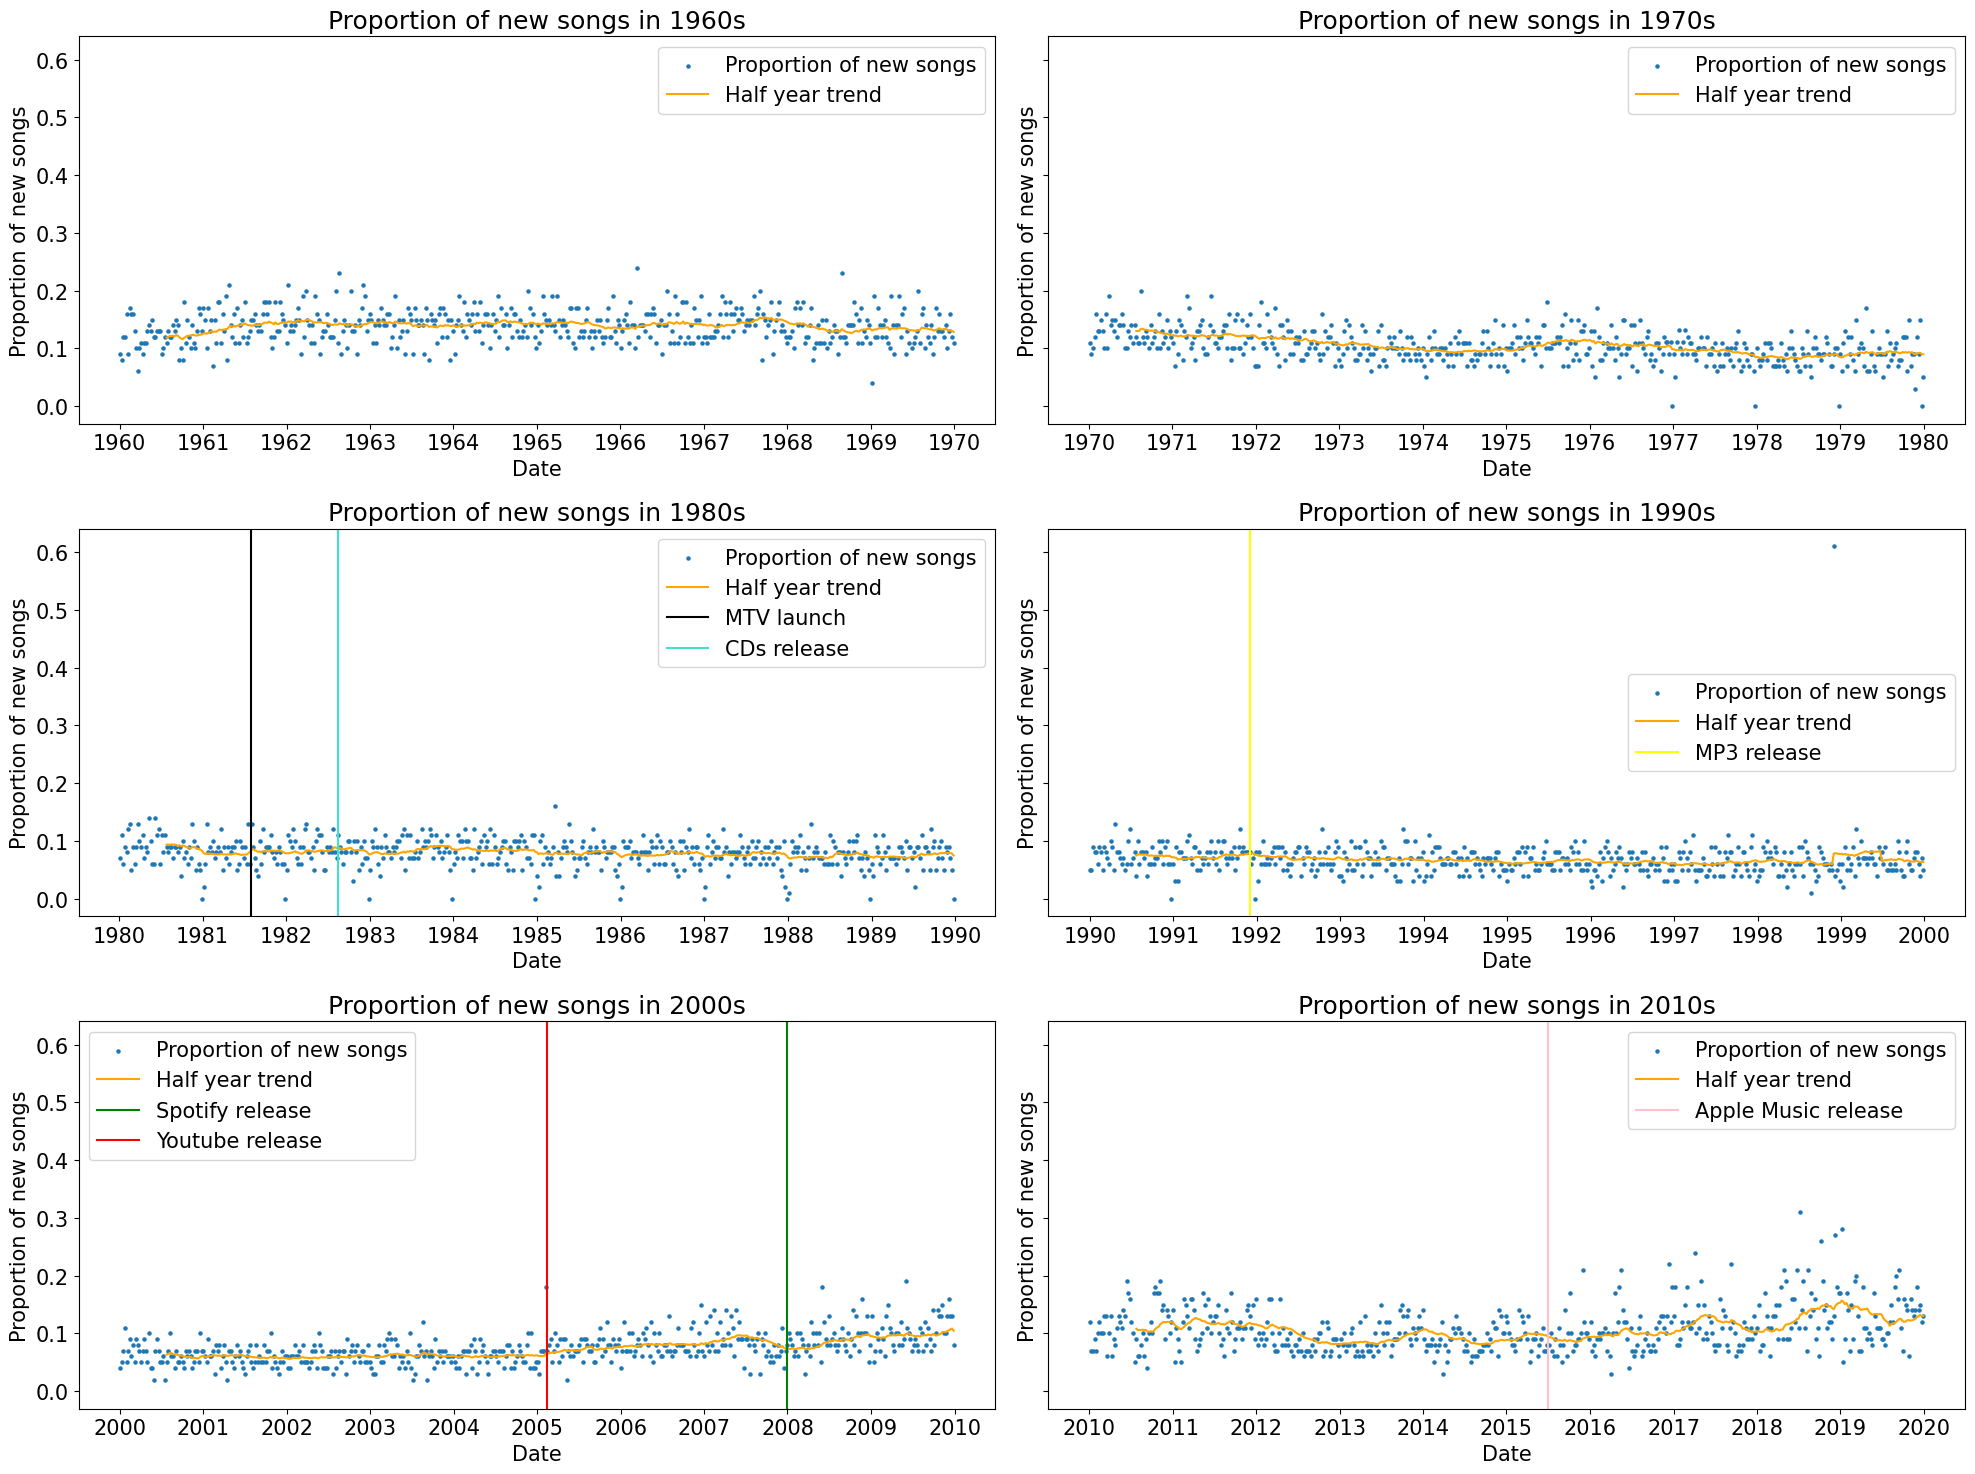

In [ ]:
billboard_hot_100["new_song"] = billboard_hot_100["last_week_position"].map(
    lambda position: True if np.isnan(position) else False)

fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["first_day_of_the_week", "new_song"]]

    cross_tab_songs = all_songs_in_decade.groupby(by="first_day_of_the_week").mean().reset_index()
    cross_tab_songs_mean = all_songs_in_decade.groupby(
        by="first_day_of_the_week").mean().rolling(window=30).mean()
    axes[row_i, col_i].scatter(x=cross_tab_songs["first_day_of_the_week"], y=cross_tab_songs["new_song"], s=5)
    axes[row_i, col_i].plot(cross_tab_songs_mean, color="orange")

    legend_elements = ["Proportion of new songs", "Half year trend"]
    for event_year, (date, color) in important_dates.items():
        if event_year >= year and event_year < year + 10:
            axes[row_i, col_i].axvline(x = date, color = color)
            legend_elements.append(important_dates_names[event_year])
    
    axes[row_i, col_i].legend(legend_elements)
    axes[row_i, col_i].set_title(f"Proportion of new songs in {year}s")
    axes[row_i, col_i].set_xlabel("Date")
    axes[row_i, col_i].set_ylabel("Proportion of new songs")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/proportion_new_songs_decades.pdf", format="pdf")
plt.show()


## Distributions of songs by same artists

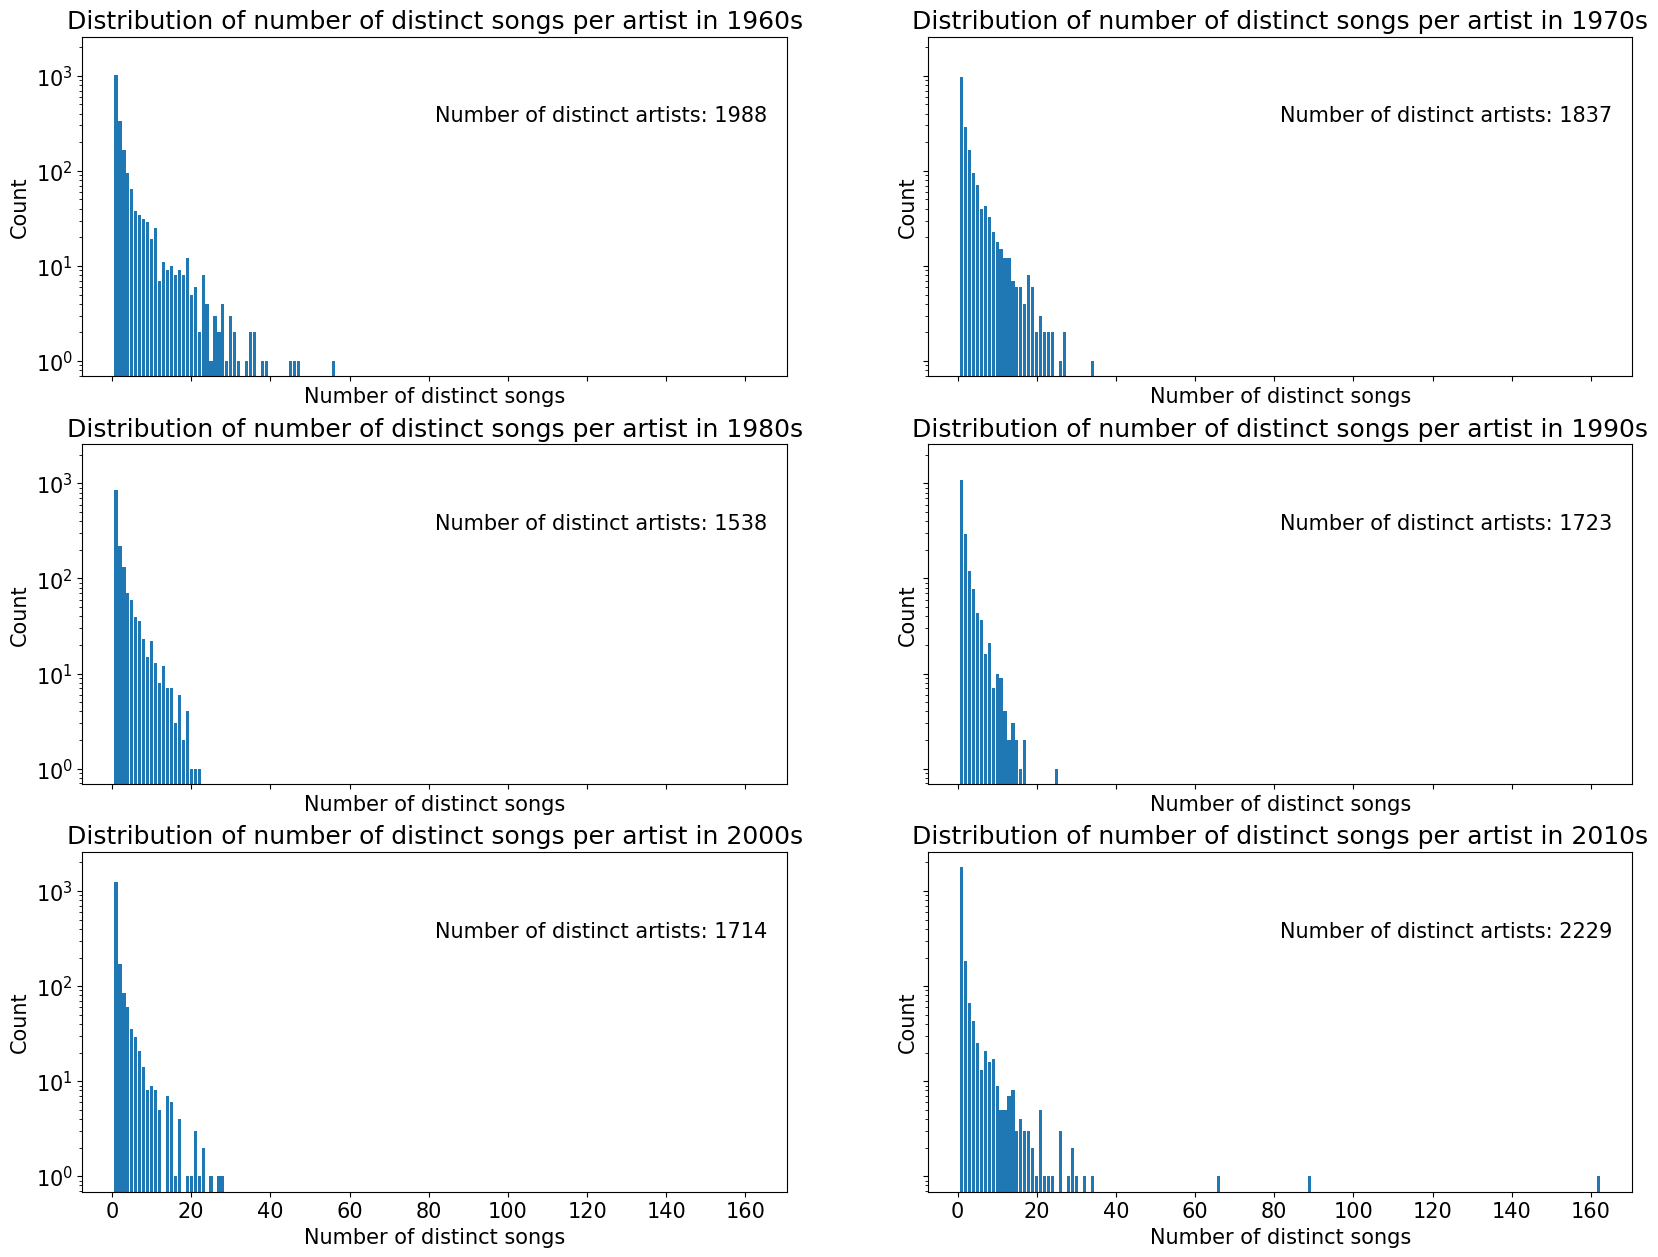

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "weeks_on_chart"]]

    count_songs = all_songs_in_decade[["artist", "song_name"]].drop_duplicates().groupby(by="artist").count().reset_index()
    number_of_songs_distribution = count_songs["song_name"].value_counts()
    axes[row_i, col_i].bar(number_of_songs_distribution.index, number_of_songs_distribution.values)
    axes[row_i, col_i].set_title(f"Distribution of number of distinct songs per artist in {year}s")
    axes[row_i, col_i].set_xlabel("Number of distinct songs")
    axes[row_i, col_i].set_ylabel("Count")
    axes[row_i, col_i].set_yscale("log")
    axes[row_i, col_i].text(0.5, 0.75, f"Number of distinct artists: {len(count_songs)}", transform=axes[row_i, col_i].transAxes)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/number_of_songs_per_artist_distribution.pdf", format="pdf")
plt.show()

## Max weeks on charts for top 10 positions for decades

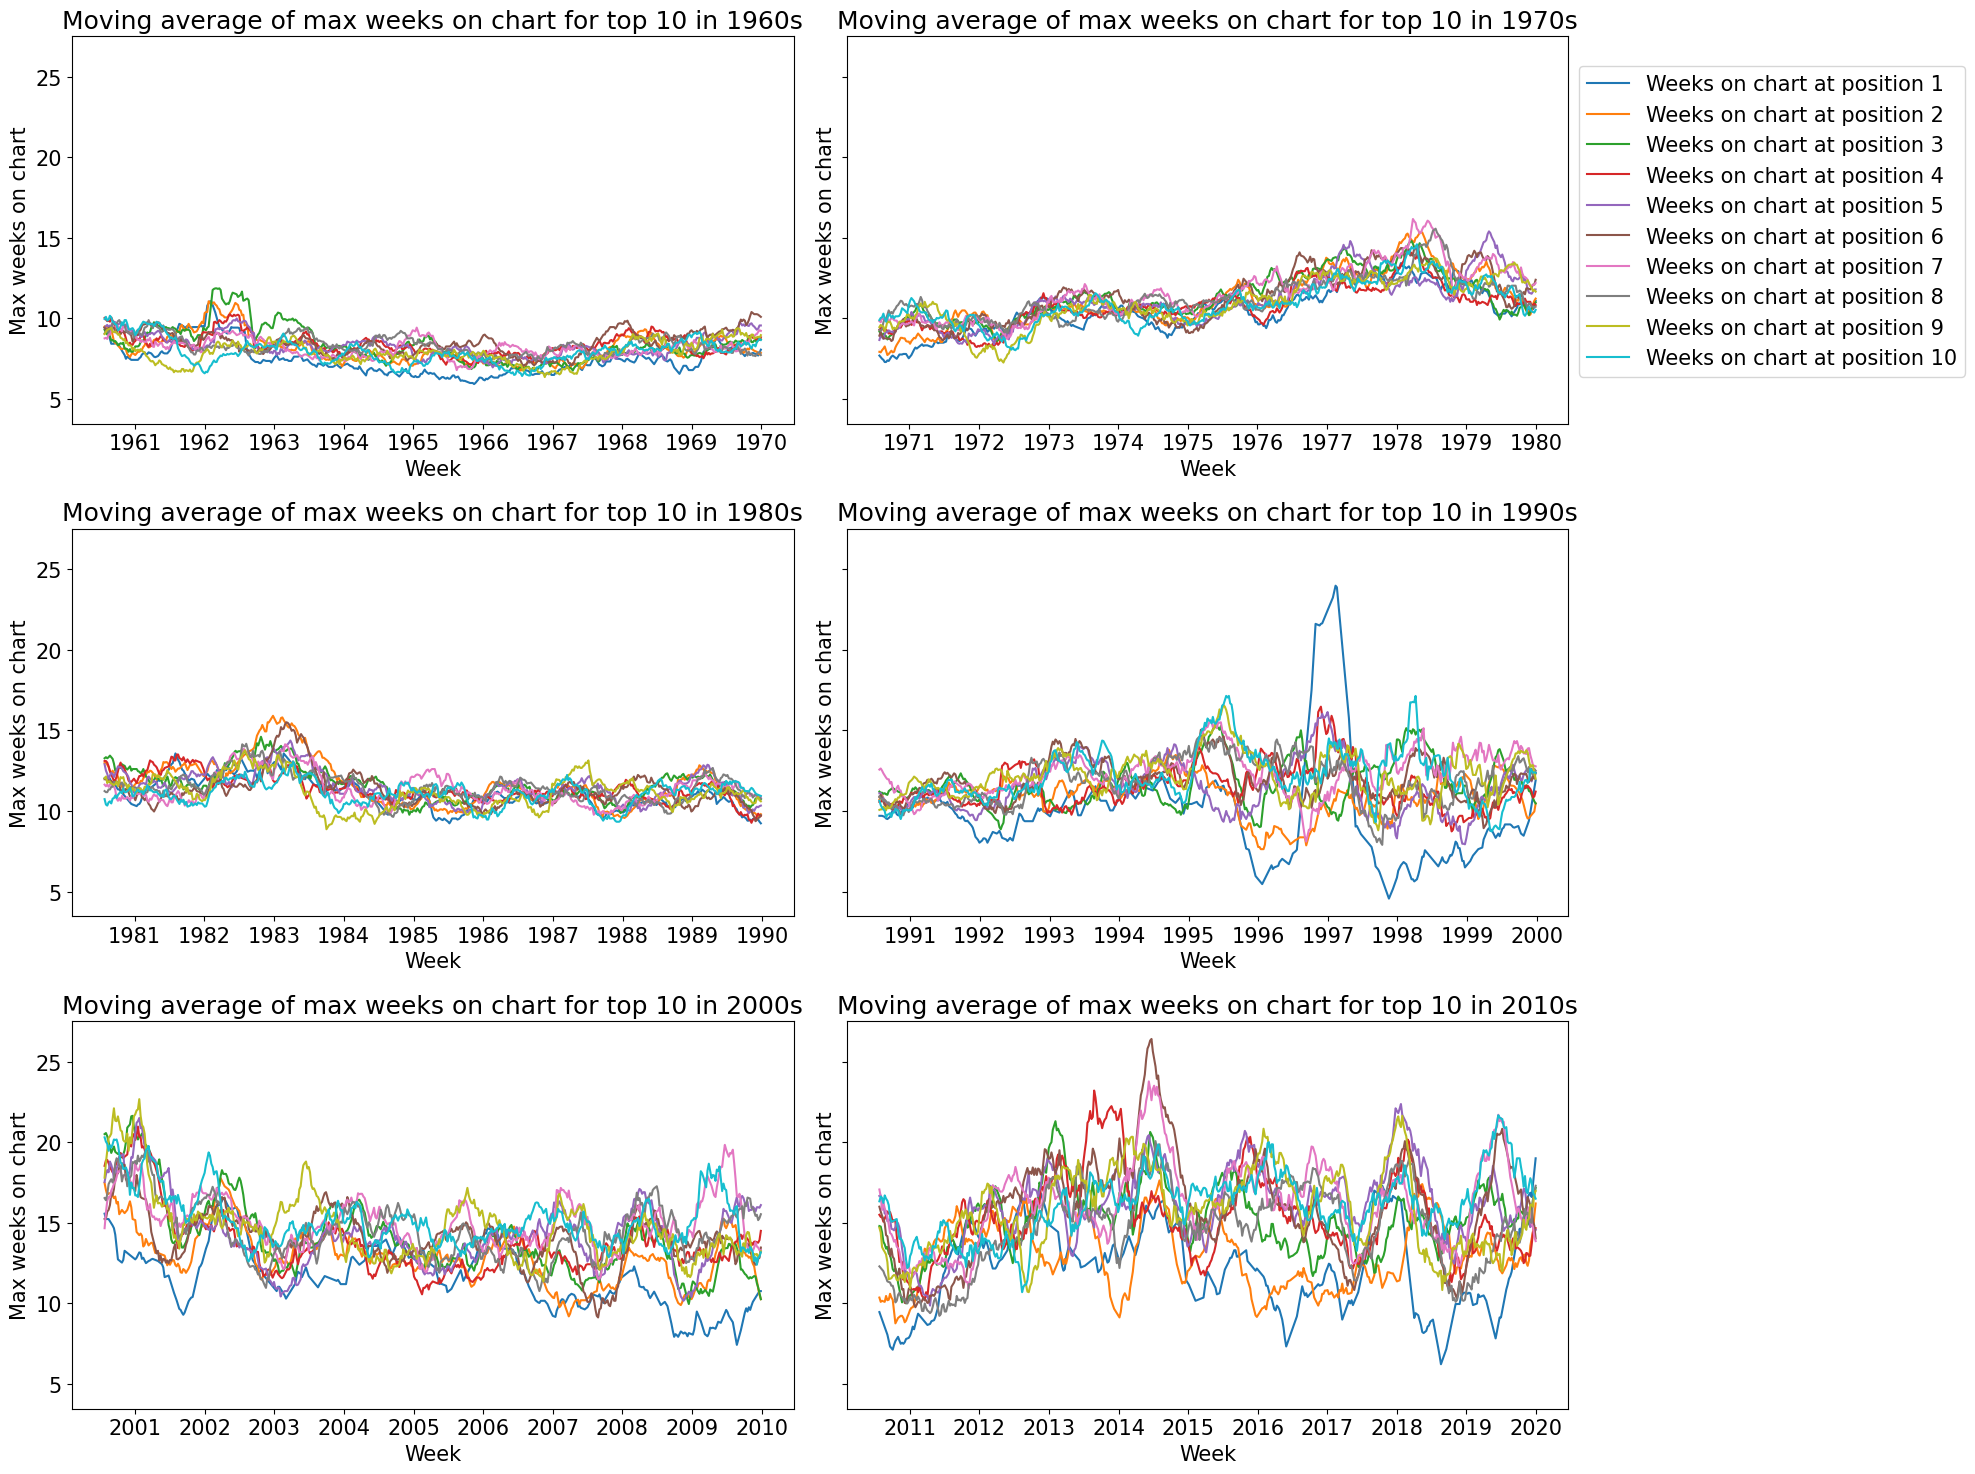

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["first_day_of_the_week", "position", "weeks_on_chart"]]

    for i in range(1, 11):
        axes[row_i, col_i].plot(all_songs_in_decade[all_songs_in_decade["position"] == i].groupby(
            ["first_day_of_the_week"])["weeks_on_chart"].max().rolling(window=30).mean())

    axes[row_i, col_i].set_title(f"Moving average of max weeks on chart for top 10 in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Max weeks on chart")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["Weeks on chart at position {}".format(i) for i in range(1, 11)], bbox_to_anchor=(1, 0.95))

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/max_weeks_on_chart_for_top_10_positions_decades.pdf", format="pdf")
plt.show()